In [1]:
# Import the Libraries
import csv
import random
import ast


import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import find_peaks, peak_prominences

In [2]:
# List of different types of Synthetic Anomalies
#
# 1.	(000 – Reverse) Reverse direction
# 2.	(001 – Noise) Add noise
# 3.	(002 – Slow) Slow down frequency
# 4.	(003 – Fast) Speed up frequency
# 5.	(004 – Insert) Insert time series from other dataset
# 6.	(005 – Shift) Shift by half cycle and reduce amplitude
# 7.	(006 – DivideRoundMultiply) Divide by 50, Round, Multiply by 100
# 8.	(007 – Sine) Replace with a sine wave
# 9.	(008 – Constant) Replace several datapoints with a constant value
# 10.	(009 – Bigger) Make peaks bigger
# 11.	(010 – Smaller) Make peaks smaller
# 12.	(011 – UpsideDown) Turn the data upside down
# 13.	(012 – SineAdd) Add sin wave to the curve
# 14.	(013 – RemovePeaks) Remove peaks change to the mean
# 15.	(014 – PeaksSameHeight) Make other peaks high like the highest peak
# 16.	(015 – Random Walk) Add random walk
# 17.	(016 – Smooth) Make the anomaly smooth by moving average
#
# 18. (ALL) - Runs through all Synthetic Anomalies

In [3]:
# List of Parameters
anomaly_format = "ALL" # Type of Anomaly
filename = "IESOToronto202120222023.txt"
filename_replacement = "Replacement_ECG_Data.txt"
train_percentage = 0.80
anomaly_range_percentage = 0.4
anomaly_range_start_percentage = 0.3 * 0.3
anomaly_range_value = 500 # 72/24 = 3 days, 288/24 = 12 days
noise_magnitude = 0.15
speed_value = 5
peaks_percentage_increase = 1.25
peaks_percentage_decrease = 0.85
random_min = -100
random_max = 100
walk_min = -100
walk_max = 100

In [4]:
# Function to Plot Results
def plot_time_series(data_input, anomaly_format, original, zoom_start, zoom_end, anomaly_start, anomaly_range):
    
    type_of_plot = "Original"
    
    if original == True:
        type_of_plot = "Original"
    else:
        type_of_plot = "Anomaly"
        

    #data_input = data_input[-5000:]
    
    index_list = list(range(len(data_input)))  # Index list (0 to 364)
    values = data_input  # Example values list

    # Define the range to be highlighted
    highlight_start = anomaly_start
    highlight_end = anomaly_start + anomaly_range

    # Plot the full data
    plt.figure(figsize=(10, 6))
    plt.plot(index_list, values, color='blue', label='Electricity Consumption')
    plt.axvspan(highlight_start, highlight_end, color='orange', alpha=0.3, label='Anomaly Range')
    plt.xlabel('Hours')
    plt.ylabel('Demand')
    plt.title('Electricity Consumption - ' + anomaly_format + ' - ' + type_of_plot)
    plt.legend()
    plt.grid(True)
    figure_name = f"Electricity Consumption - {anomaly_format} - {type_of_plot}.png"
    plt.savefig(figure_name)
    plt.show()
    plt.close()

    # Plot the zoomed-in section
    plt.figure(figsize=(10, 6))
    plt.plot(index_list, values, color='blue', label='Electricity Consumption')
    plt.axvspan(highlight_start, highlight_end, color='orange', alpha=0.3, label='Anomaly Range')
    plt.xlabel('Hours')
    plt.ylabel('Demand')
    plt.title('Electricity Consumption - ' + anomaly_format + ' - ' + type_of_plot + ' - Zoom In')
    plt.legend()
    plt.grid(True)
    plt.xlim(zoom_start, zoom_end)
    figure_name = f"Electricity Consumption - {anomaly_format} - {type_of_plot} - Zoom In.png"
    plt.savefig(figure_name)
    plt.show()
    plt.close()
    
    return

In [5]:
# Miscellanous Functions

# Determine if Arrays are Equal (length and content)
def are_arrays_equal(arr1, arr2):
    # Check if the arrays have the same length
    if len(arr1) != len(arr2):
        print("Lengths are Different")
        return False

    # Compare each element in the arrays
    for i in range(len(arr1)):
        if arr1[i] != arr2[i]:
            print("Values are Different")
            return False

    return True

# Reverse a section of the Array
def reverse_section(arr, start, end):
    if start < 0 or end >= len(arr) or start > end:
        return "Invalid section boundaries"

    arr[start:end + 1] = arr[start:end + 1][::-1]
    return arr

# Function to flatten the nested list
def flatten_list(nested):
    flat_list = []
    for item in nested:
        if isinstance(item, list):
            flat_list.extend(flatten_list(item))
        else:
            flat_list.append(item)
    return flat_list

def shift_right(arr, positions):
    # Shift the elements of the array to the right by the specified number of positions.
    return arr[-positions:] + arr[:-positions]

def shift_left(arr, positions):
    #Shift the elements of the array to the left by the specified number of positions.
    return arr[positions:] + arr[:positions]

# Z-Normalize a list
def z_normalize(data):
    # Check if data is a list of lists
    if any(isinstance(item, list) for item in data):
        flattened_data = [item for sublist in data for item in sublist]
    else:
        flattened_data = data

    mean_value = sum(flattened_data) / len(flattened_data)
    std_dev = (sum((x - mean_value) ** 2 for x in flattened_data) / len(flattened_data)) ** 0.5
    z_normalized = [(x - mean_value) / std_dev for x in flattened_data]
    return z_normalized

In [6]:
### Creation of Anomalies

1.	(000 – Reverse) Reverse direction


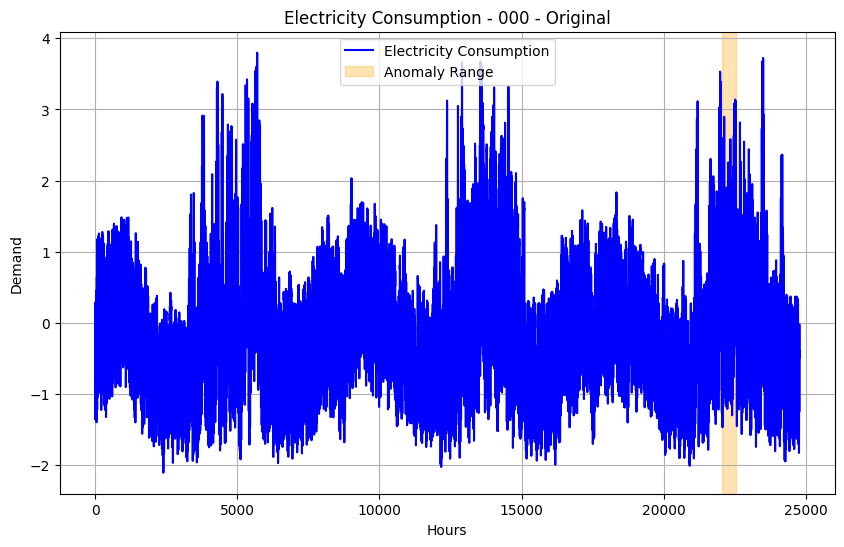

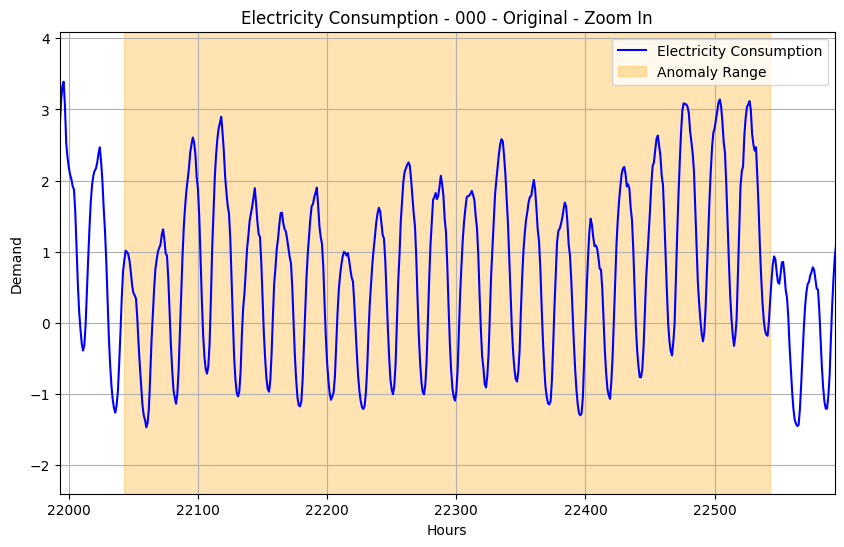

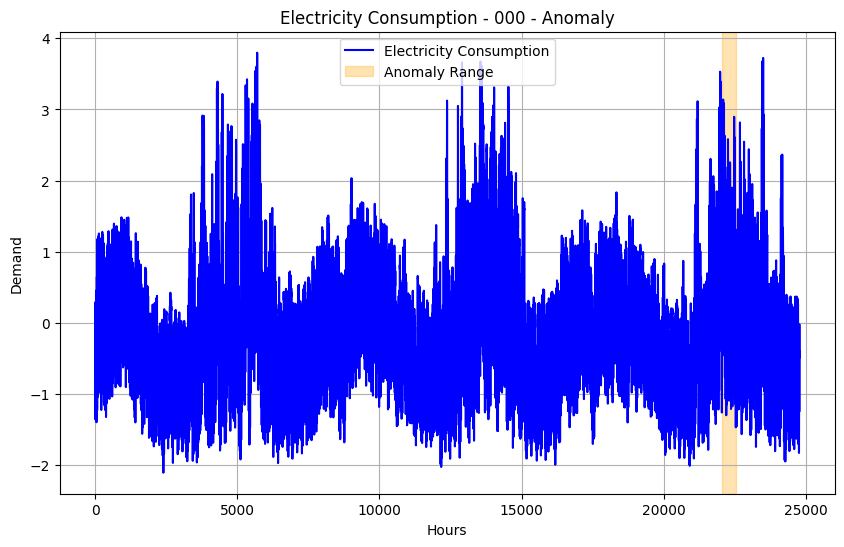

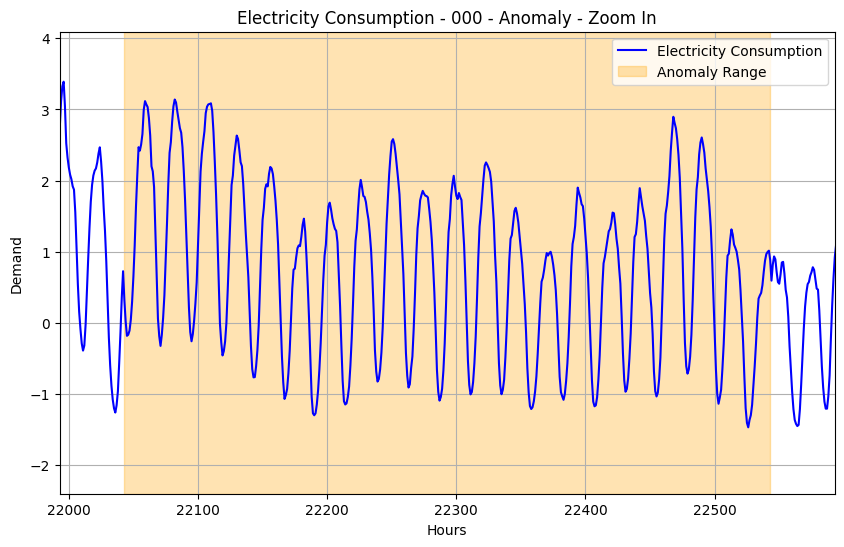

In [7]:
### 1.	(000 – Reverse) Reverse direction
if anomaly_format == "000" or anomaly_format == "ALL":

    print("1.	(000 – Reverse) Reverse direction")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)
    
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Reverse the direction of the anomaly_range
    start_index = highlight_start
    end_index = highlight_end
    anomaly = reverse_section(data[:], start_index, end_index)

    # Z-normalize data
    data = z_normalize(data)
    anomaly = z_normalize(anomaly)

    # Plot the Time Series + Anomaly
    plot_time_series(data, "000", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    
    plot_time_series(anomaly, "000", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    #filename_save = (f"000_IESO_Anomaly_{filename.replace(".txt", "")}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt")
    filename_save = f"000_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"

    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')
        
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])


2.	(001 – Noise) Add noise


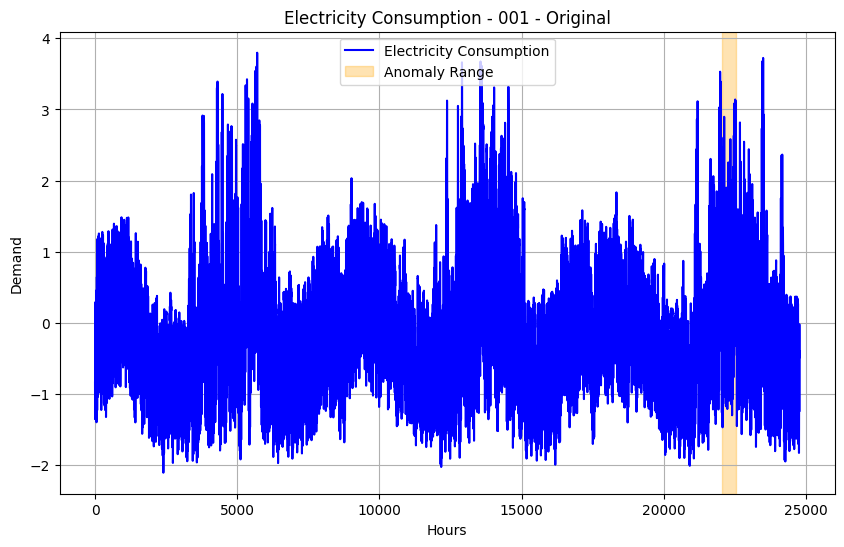

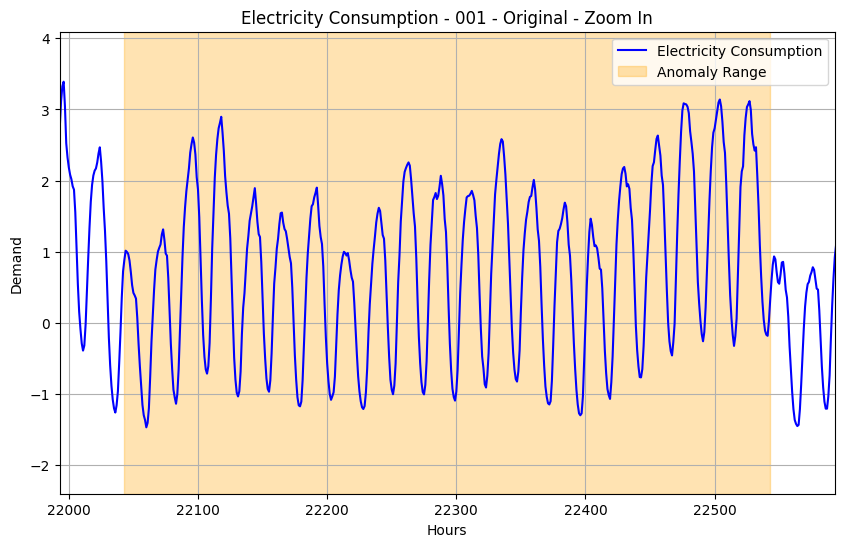

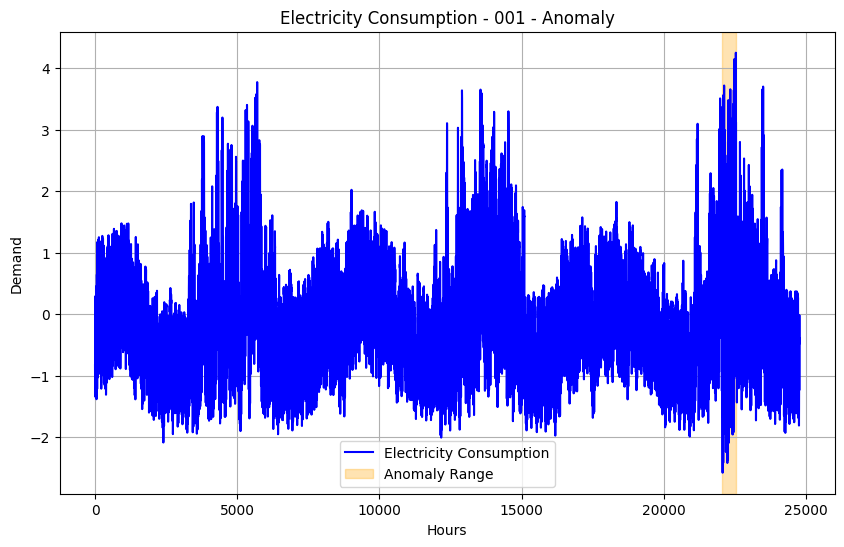

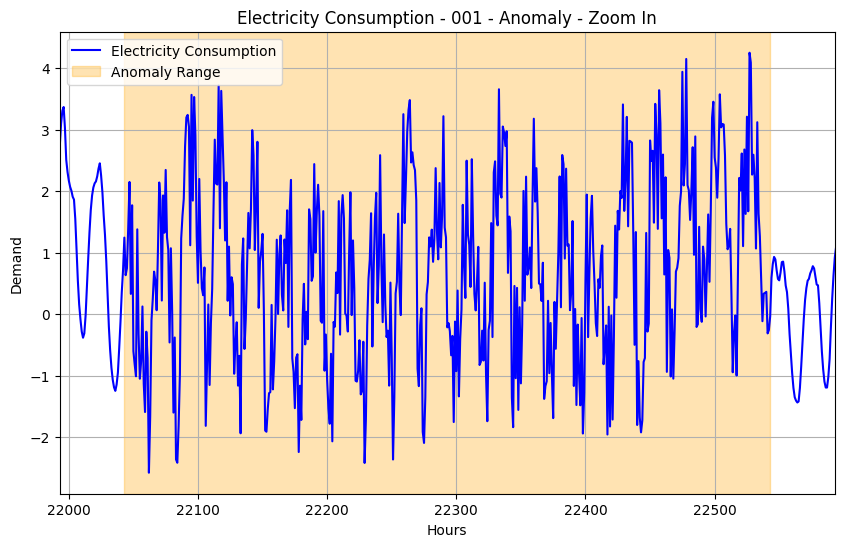

In [8]:
### "2.	(001 – Noise) Add noise"
if anomaly_format == "001" or anomaly_format == "ALL":
    
    print("2.	(001 – Noise) Add noise")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)
    
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Start and End Values of range
    start_index = highlight_start
    end_index = highlight_end
    
    # Add anomaly
    anomaly = data[:]  # Create a copy of the original list
        
    # Flattening the list
    flattened_list = flatten_list(anomaly)
    
    max_value = max(flattened_list)
    
    for i in range(len(flattened_list)):
        if i >= start_index and i <= end_index:
            flattened_list[i] = flattened_list[i] + max_value*random.uniform(-noise_magnitude, noise_magnitude)
    
    data = data[:]
    anomaly = flattened_list[:]

    # Z-normalize data
    data = z_normalize(data)
    anomaly = z_normalize(anomaly)
    
    # Plot the Time Series + Anomaly
    plot_time_series(data, "001", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    
    plot_time_series(anomaly, "001", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    filename_save = f"001_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"

    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')
        
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])

3.	(002 – Slow) Slow down frequency


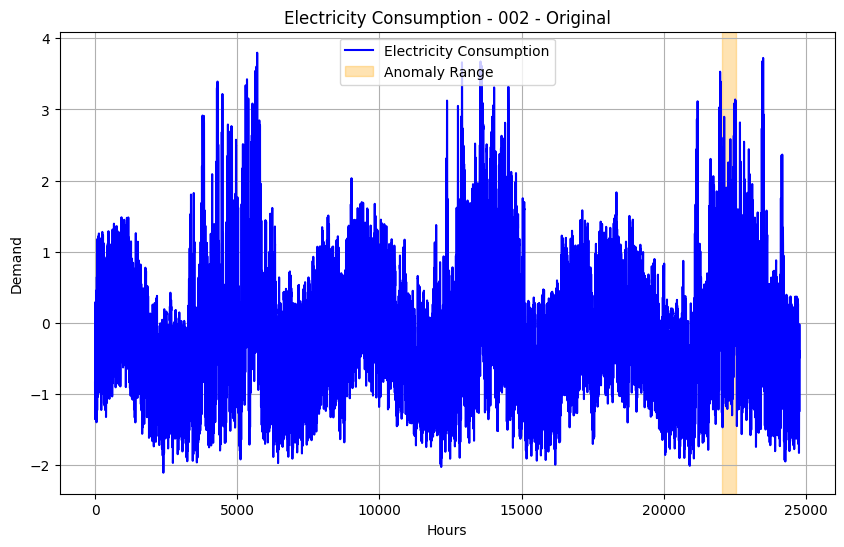

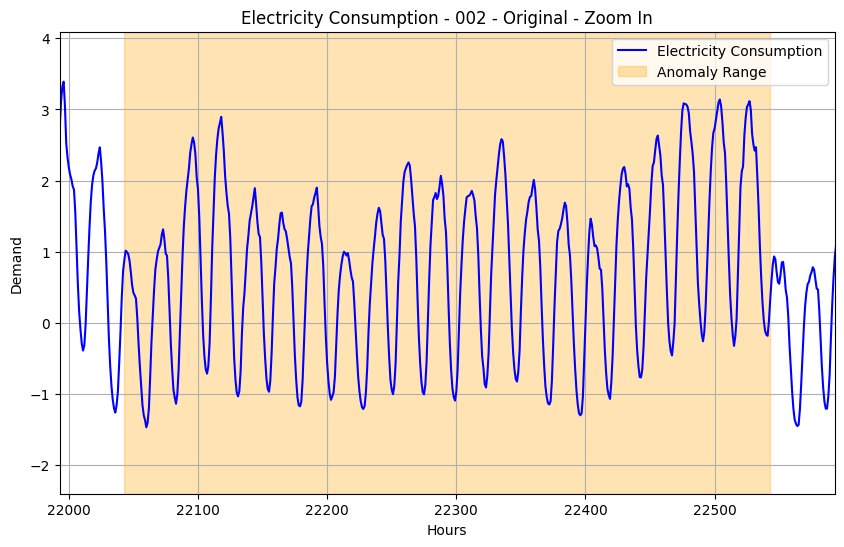

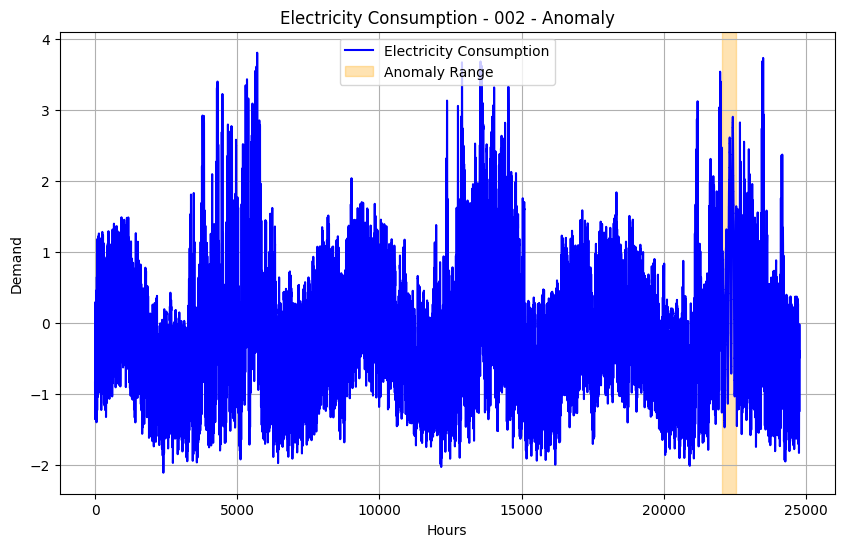

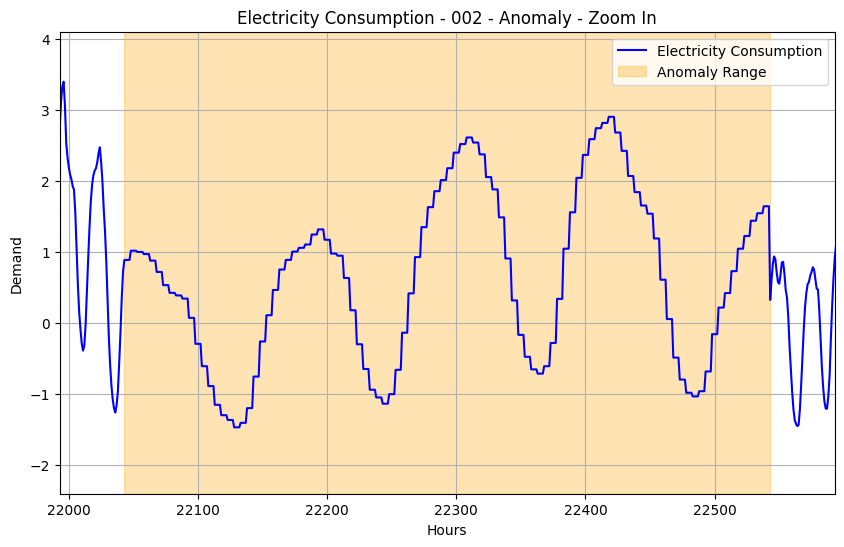

In [9]:
### "3.	(002 – Slow) Slow down frequency"
if anomaly_format == "002" or anomaly_format == "ALL":
    
    print("3.	(002 – Slow) Slow down frequency")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)
    
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Start and End Values of range
    start_index = highlight_start
    end_index = highlight_end
    
    # Add anomaly
    anomaly = data[:]  # Create a copy of the original list
        
    # Flattening the list
    flattened_list = flatten_list(anomaly)
    
    data = data[:]
    data = z_normalize(data)
   
    # Plot the Time Series
    plot_time_series(data, "002", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    


    # Create Anomaly
    anomaly = flattened_list[:]
    anomaly_before = anomaly[:start_index]
    anomaly_after = anomaly[end_index:]

    i = 0
    j = 0
    anomaly_range = 0
    anomaly_insert = []
    total = 0
    for i in range(start_index, end_index):
        if (total <= anomaly_range_value):
            anomaly_value = anomaly[i]
            for j in range(speed_value):
                if (total <= anomaly_range_value):
                    anomaly_insert.append(anomaly_value)
                    total = total + 1

    anomaly_range = anomaly_range_value
    anomaly = anomaly_before + anomaly_insert[0:anomaly_range] + anomaly_after
    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range

    zoom_start = highlight_start - 50
    zoom_end = highlight_end + 50

    anomaly = z_normalize(anomaly)
    
    # Plot Anomaly
    plot_time_series(anomaly, "002", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    #highlight_end = highlight_end - 50
    filename_save = f"002_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"
    
    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')    
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])

4.	(003 – Fast) Speed up frequency


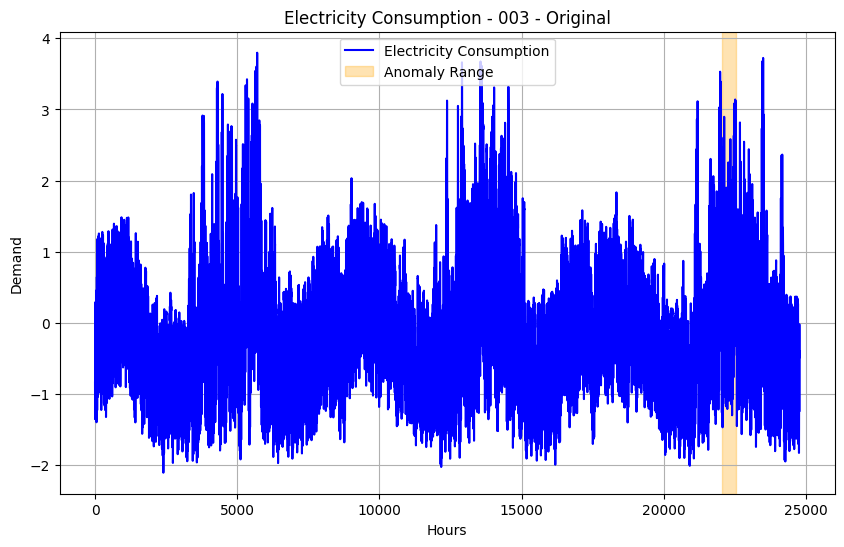

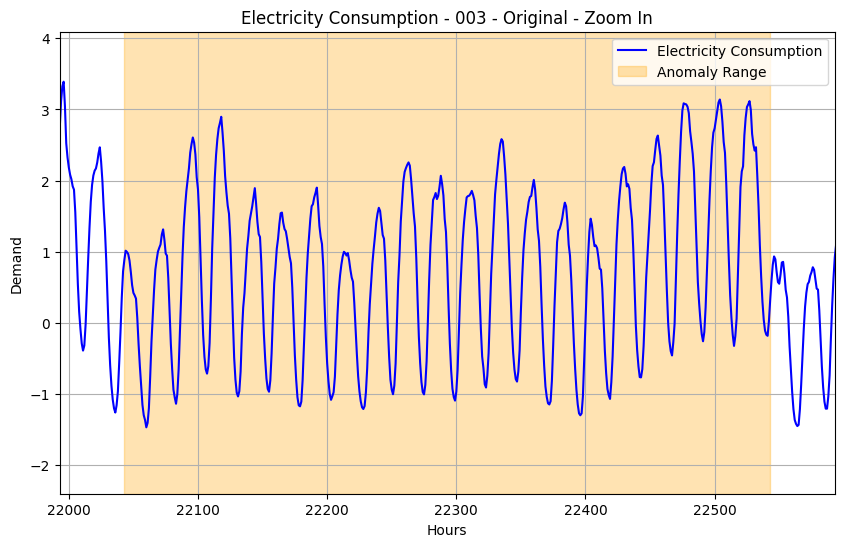

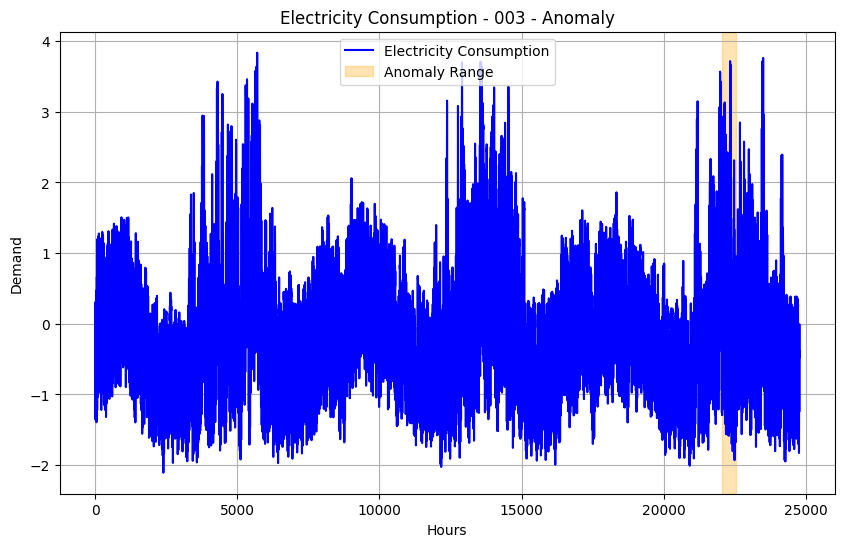

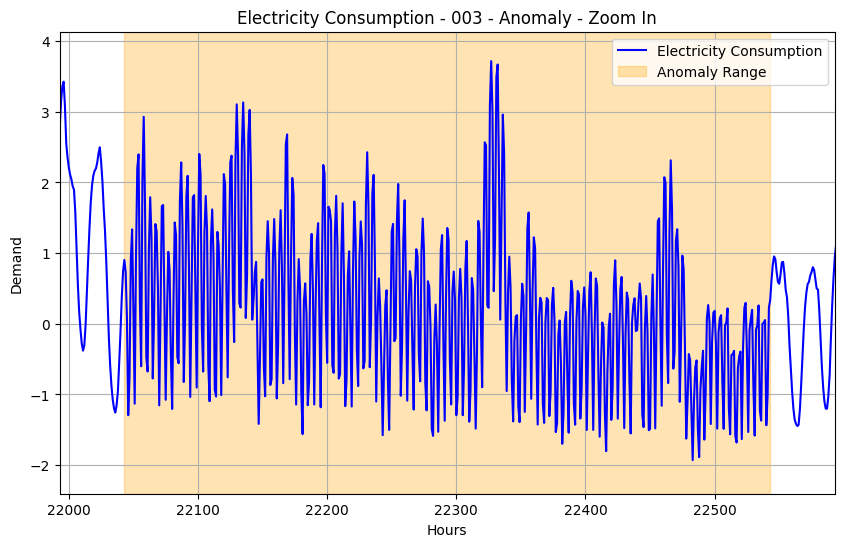

In [10]:
### "4.	(003 – Fast) Speed up frequency"
if anomaly_format == "003" or anomaly_format == "ALL":
    
    print("4.	(003 – Fast) Speed up frequency")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)
    
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Start and End Values of range
    start_index = highlight_start
    end_index = highlight_end
    
    # Add anomaly
    anomaly = data[:]  # Create a copy of the original list
        
    # Flattening the list
    flattened_list = flatten_list(anomaly)
    
    data = data[:]

    data = z_normalize(data)
   
    # Plot the Time Series
    plot_time_series(data, "003", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    


    # Create Anomaly
    anomaly = flattened_list[:]

    # Speed Up
    anomaly_insert = anomaly[start_index::speed_value]
    length = len(anomaly_insert)

    anomaly_range = anomaly_range_value
    anomaly_before = anomaly[:start_index]
    anomaly_after = anomaly[start_index+anomaly_range:]
    anomaly = anomaly_before + anomaly_insert[:anomaly_range] + anomaly_after
    
    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range

    zoom_start = highlight_start - 50
    zoom_end = highlight_end + 50

    anomaly = z_normalize(anomaly)
    
    # Plot Anomaly
    plot_time_series(anomaly, "003", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    filename_save = f"003_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"
    
    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')    
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])

5.	(004 – Insert) Insert time series from other dataset


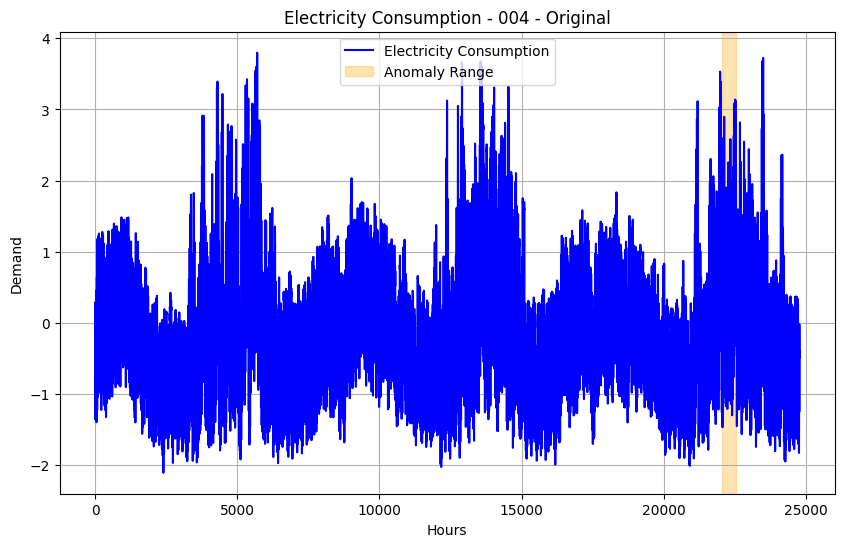

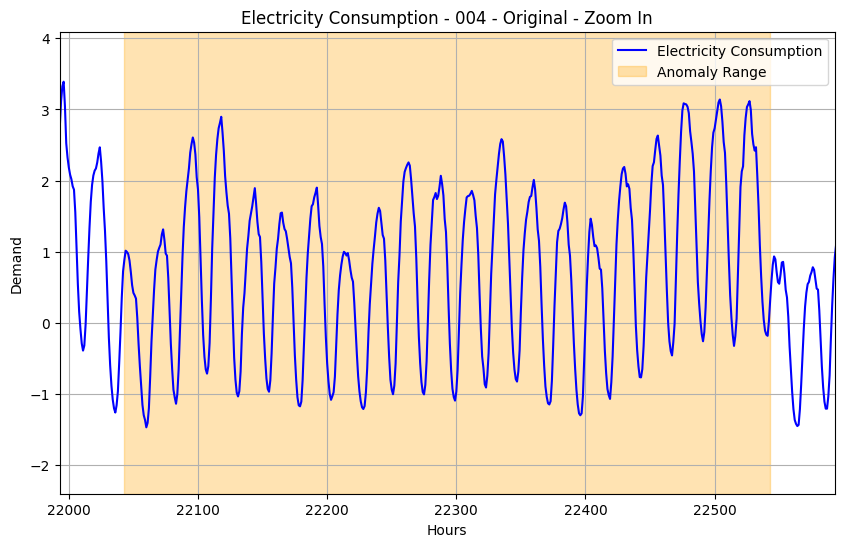

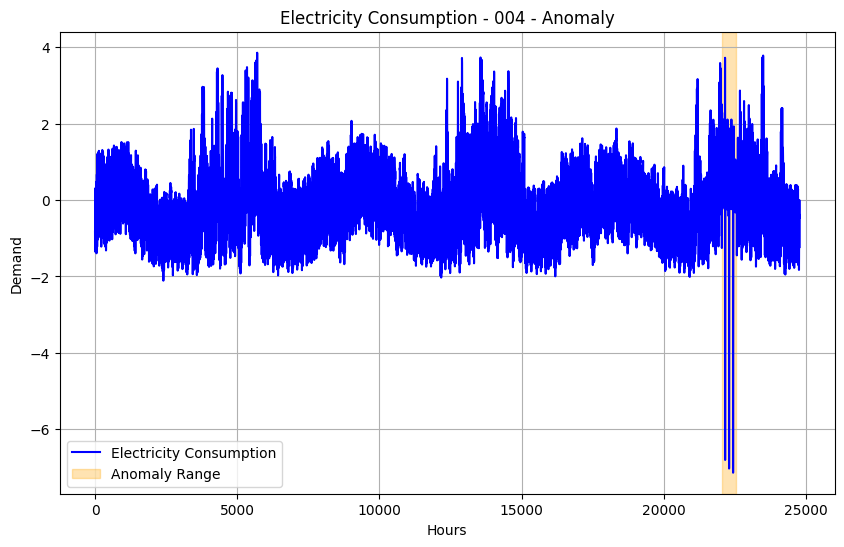

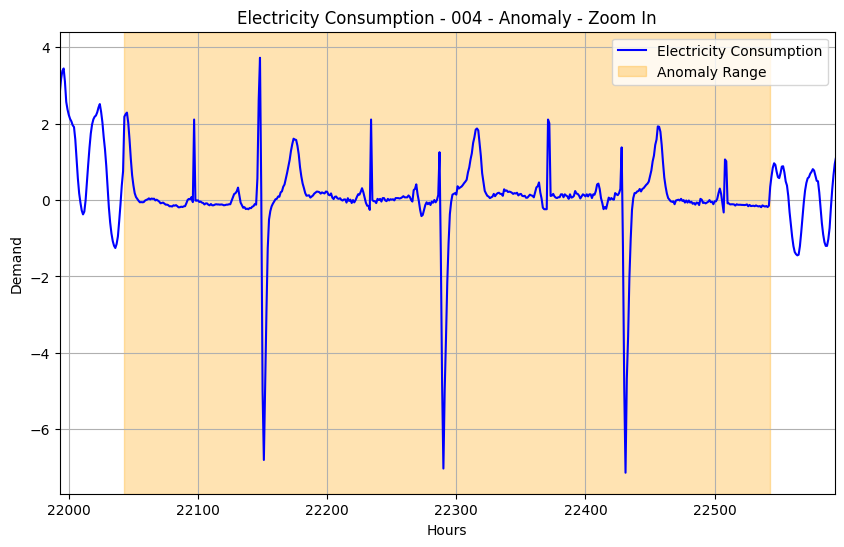

In [11]:
### "5.	(004 – Insert) Insert time series from other dataset"
if anomaly_format == "004" or anomaly_format == "ALL":
    
    print("5.	(004 – Insert) Insert time series from other dataset")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)

    # Get data from ECG
    data_replacement = []
    
    with open(filename_replacement, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data_replacement.append(numeric_row)
            
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Insert in anomaly_range
    start_index = highlight_start
    end_index = highlight_end
    range_index = highlight_end - highlight_start
    mean_value = np.mean(data)
    anomaly = data[:]
    anomaly[start_index:end_index] = np.array(data_replacement[0:range_index]) * 1000.0 + mean_value

    # Z-normalize data
    data = z_normalize(data)
    anomaly = z_normalize(anomaly)

    # Plot the Time Series + Anomaly
    plot_time_series(data, "004", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    
    plot_time_series(anomaly, "004", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    filename_save = f"004_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"
    
    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')    
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])

6.	(005 – Shift) Shift by half cycle and reduce amplitude


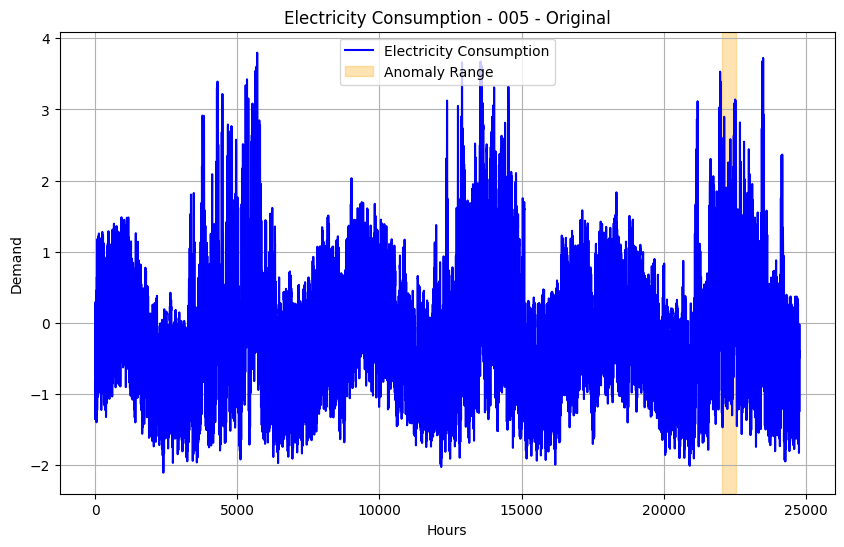

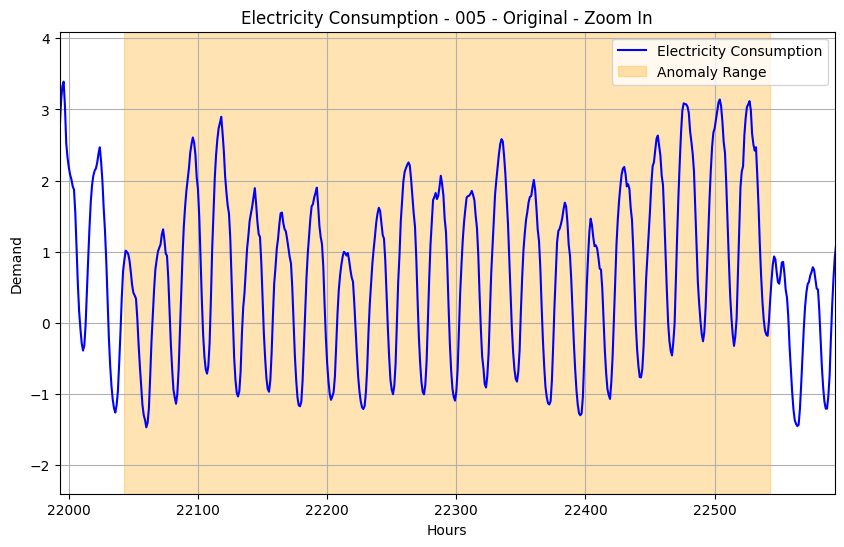

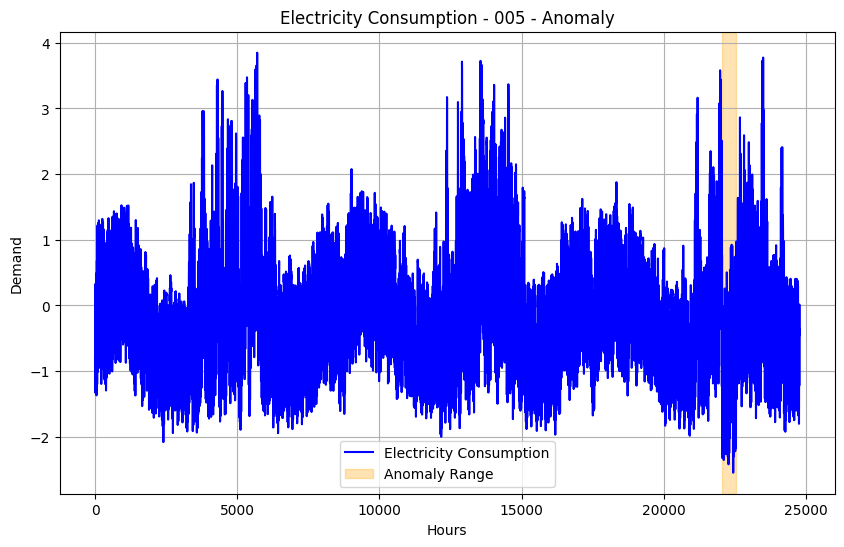

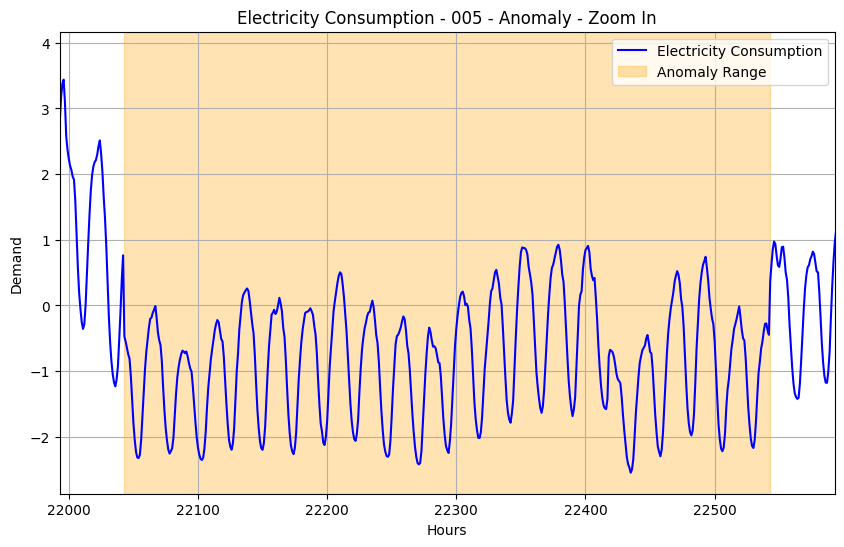

In [12]:
### "6.	(005 – Shift) Shift by half cycle and reduce amplitude"
if anomaly_format == "005" or anomaly_format == "ALL":
    
    print("6.	(005 – Shift) Shift by half cycle and reduce amplitude")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)
    
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Reverse the direction of the anomaly_range
    start_index = highlight_start
    end_index = highlight_end

    flattened_list = flatten_list(data)
    anomaly = flattened_list[:]

    shift_amount = int(anomaly_range * 0.25)
    anomaly[start_index:end_index] = shift_left(anomaly[start_index:end_index], shift_amount)

    # Convert the selected range to numeric type (assuming it's a list)
    anomaly[start_index:end_index] = [float(value) for value in anomaly[start_index:end_index]]
    # Scaling factor to reduce amplitude (e.g., 0.5 to reduce by half)
    scale_factor = 0.75
    # Reduce amplitude within the specified range
    anomaly[start_index:end_index] = [value * scale_factor for value in anomaly[start_index:end_index]]

    # Z-normalize data
    data = z_normalize(data)
    anomaly = z_normalize(anomaly)

    # Plot the Time Series + Anomaly
    plot_time_series(data, "005", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    
    plot_time_series(anomaly, "005", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    filename_save = f"005_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"
    
    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')    
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])

7.	(006 – DivideRoundMultiply) Divide by 50, Round, Multiply by 100


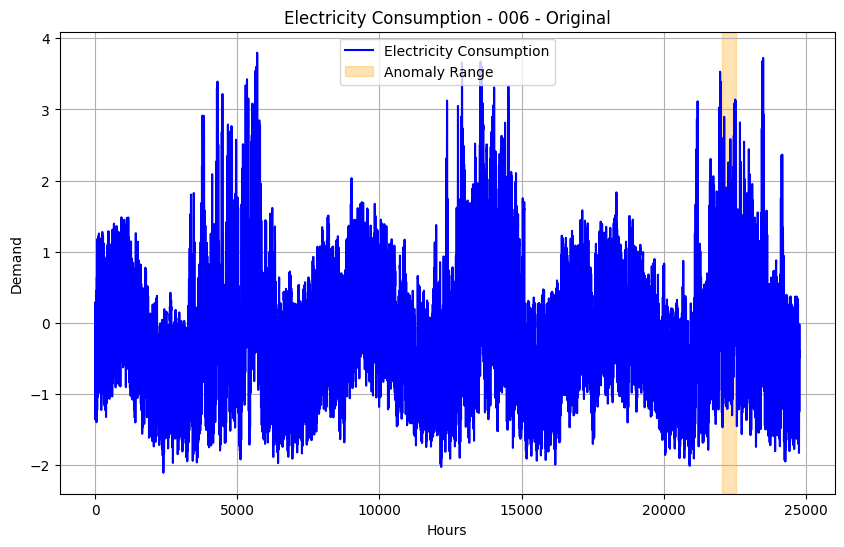

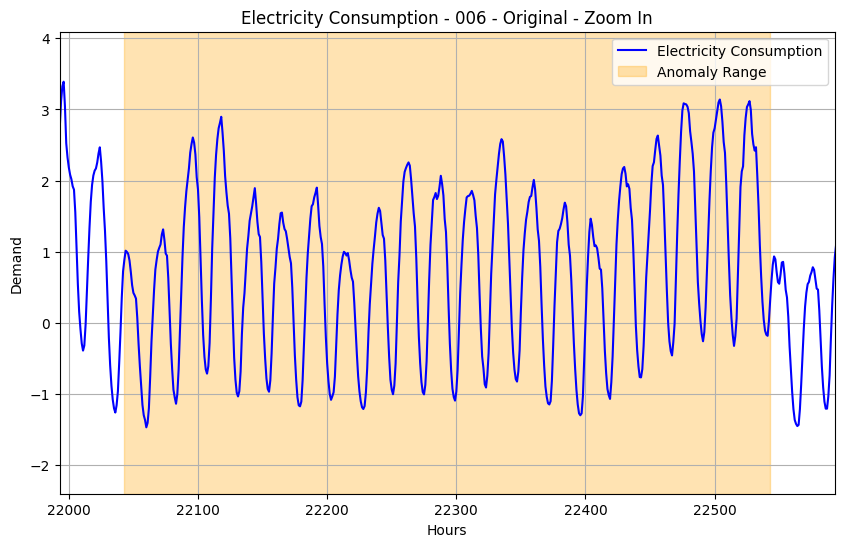

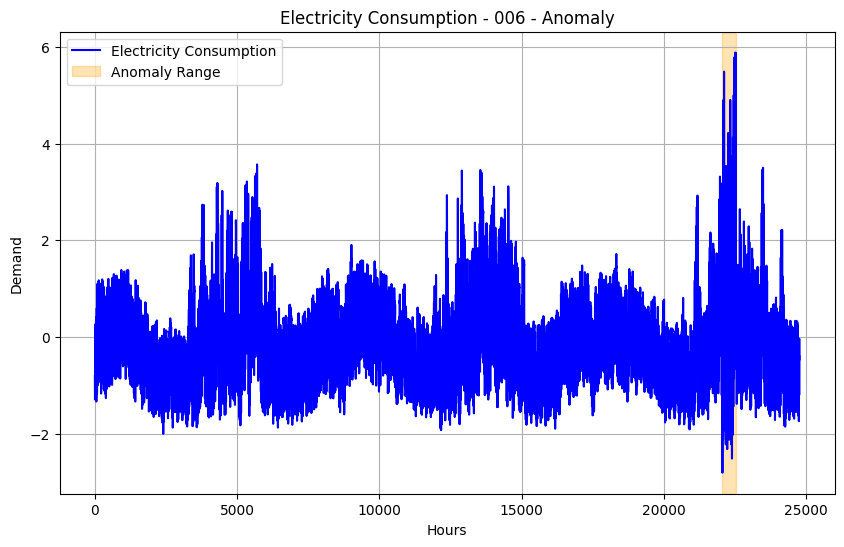

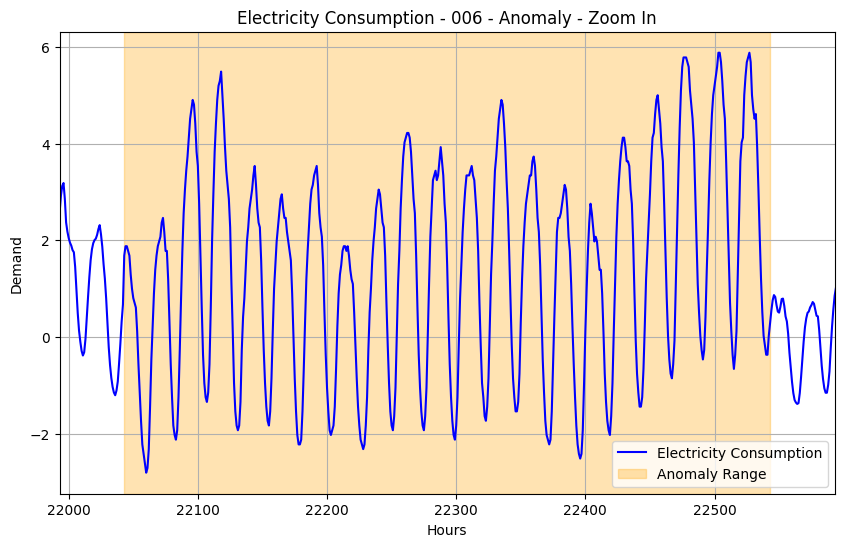

In [13]:
### "7.	(006 – DivideRoundMultiply) Divide by 50, Round, Multiply by 100"
if anomaly_format == "006" or anomaly_format == "ALL":
    
    print("7.	(006 – DivideRoundMultiply) Divide by 50, Round, Multiply by 100")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)
    
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Reverse the direction of the anomaly_range
    start_index = highlight_start
    end_index = highlight_end

    flattened_list = flatten_list(data)
    anomaly = flattened_list[:]

    mean_value = np.mean(anomaly)
    
    for i in range(start_index, end_index):
        anomaly[i] = round(anomaly[i]/50.0)*100.0 - mean_value

    # Z-normalize data
    data = z_normalize(data)
    anomaly = z_normalize(anomaly)

    # Plot the Time Series + Anomaly
    plot_time_series(data, "006", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    
    plot_time_series(anomaly, "006", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    filename_save = f"006_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"
    
    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')    
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])

8.	(007 – Sine) Replace with a sine wave


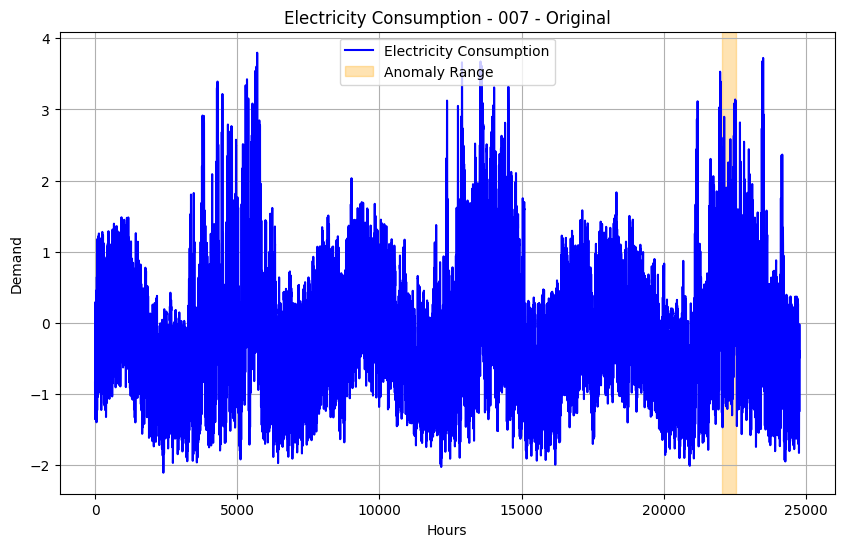

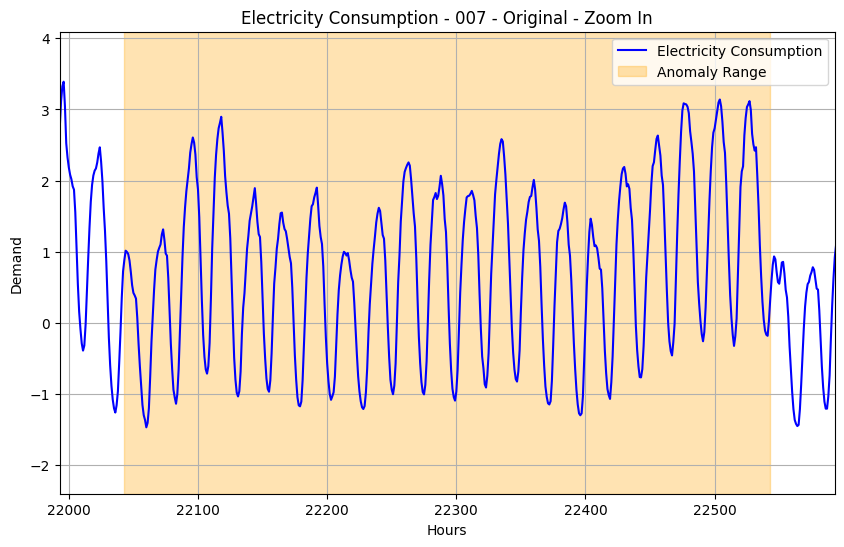

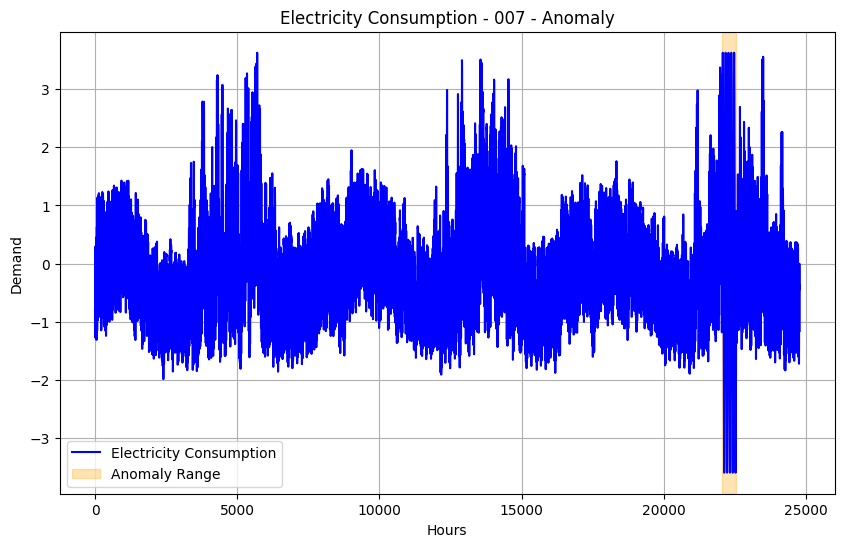

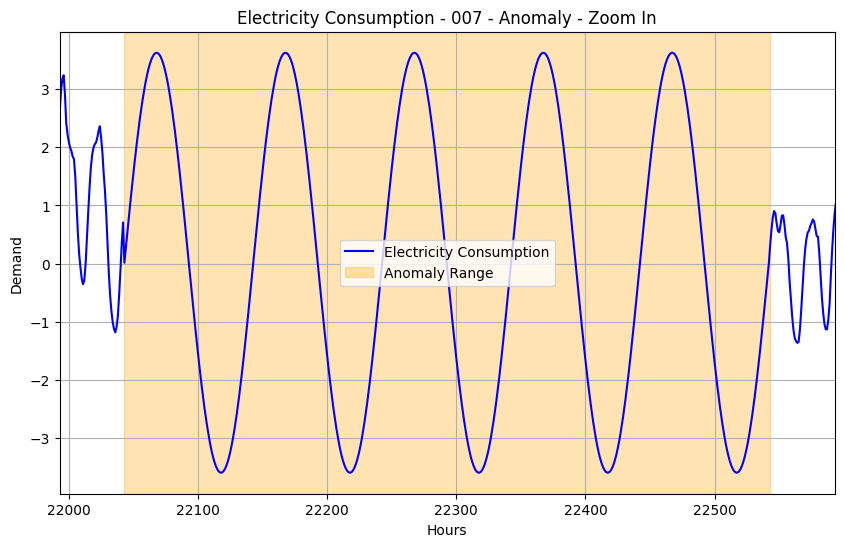

In [14]:
### 8.	(007 – Sine) Replace with a sine wave
if anomaly_format == "007" or anomaly_format == "ALL":
    
    print("8.	(007 – Sine) Replace with a sine wave")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)
    
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Start and End Values of range
    start_index = highlight_start
    end_index = highlight_end
    
    # Add anomaly
    anomaly = data[:]  # Create a copy of the original list
        
    # Flattening the list
    flattened_list = flatten_list(anomaly)
    
    max_value = max(flattened_list)
    mean_value = np.mean(flattened_list)
    max_with_mean = max_value - mean_value
    
    data = data[:]
    anomaly = flattened_list[:]
    
    # Sine Wave Parameters
    amplitude = max_with_mean
    frequency = 5  # Frequency of the sine wave in Hz
    time = np.linspace(0, 1, anomaly_range)  # Generating 1000 time points from 0 to 1 (in seconds)
    # Generate the sine wave
    sine_wave = amplitude * np.sin(2 * np.pi * frequency * time) + mean_value
        
    current = highlight_start
    i = 0
    while current < highlight_end:
        anomaly[current] = sine_wave[i]
        current = current + 1
        i = i + 1

    # Z-normalize data
    data = z_normalize(data)
    anomaly = z_normalize(anomaly)

    # Plot the Time Series + Anomaly
    plot_time_series(data, "007", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    
    plot_time_series(anomaly, "007", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    filename_save = f"007_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"
    
    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')    
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])

9.	(008 – Constant) Replace several datapoints with a constant value


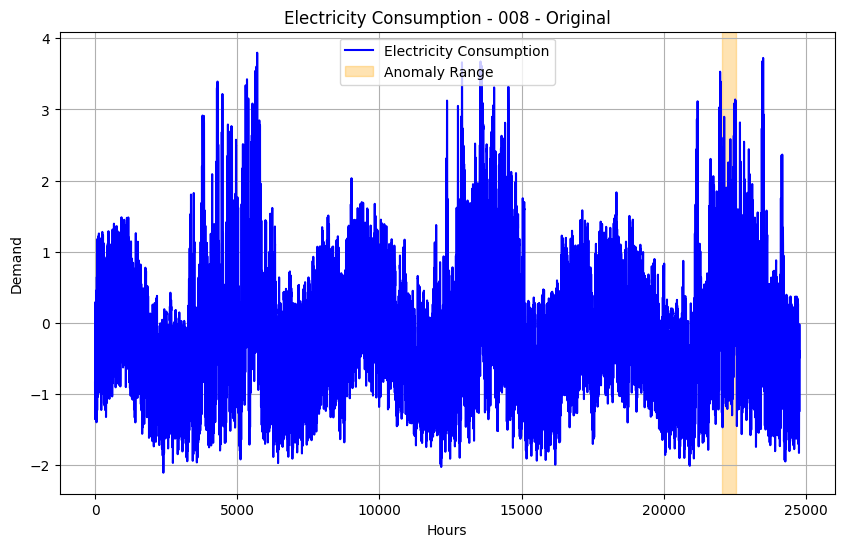

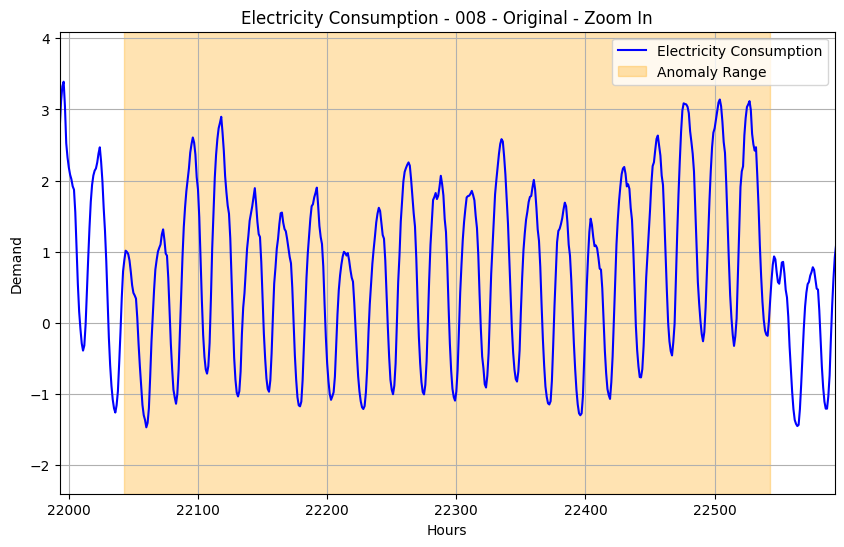

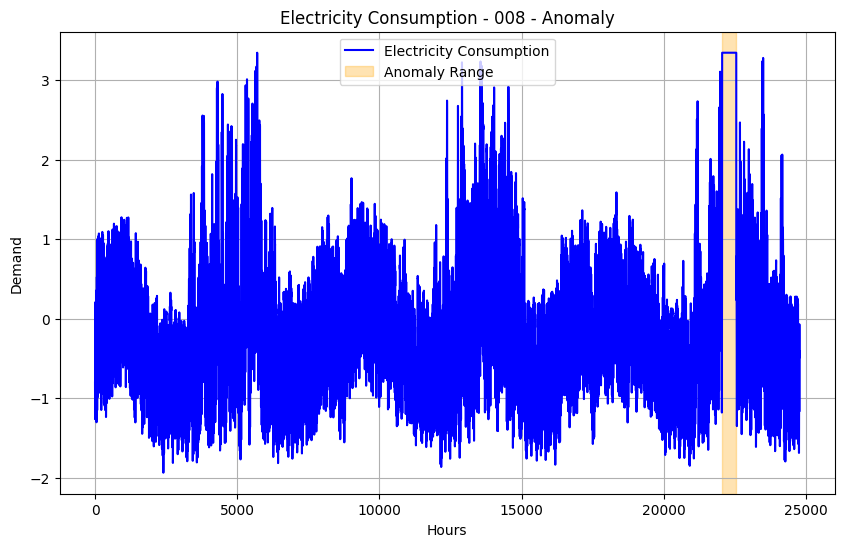

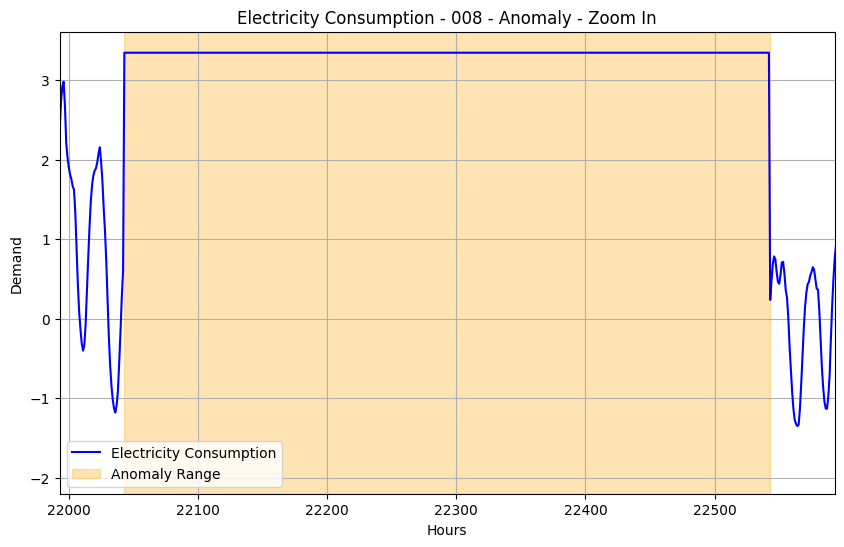

In [15]:
### "9.	(008 – Constant) Replace several datapoints with a constant value"
if anomaly_format == "008" or anomaly_format == "ALL":
    
    print("9.	(008 – Constant) Replace several datapoints with a constant value")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)
    
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Start and End Values of range
    start_index = highlight_start
    end_index = highlight_end
    
    # Add anomaly
    anomaly = data[:]  # Create a copy of the original list
        
    # Flattening the list
    flattened_list = flatten_list(anomaly)
    
    max_value = max(flattened_list)
    
    data = data[:]
    anomaly = flattened_list[:]
    
    current = highlight_start
    while current < highlight_end:
        anomaly[current] = max_value
        current = current + 1

    # Z-normalize data
    data = z_normalize(data)
    anomaly = z_normalize(anomaly)

    # Plot the Time Series + Anomaly
    plot_time_series(data, "008", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    
    plot_time_series(anomaly, "008", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    filename_save = f"008_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"
    
    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')    
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])

10.	(009 – Bigger) Make peaks bigger


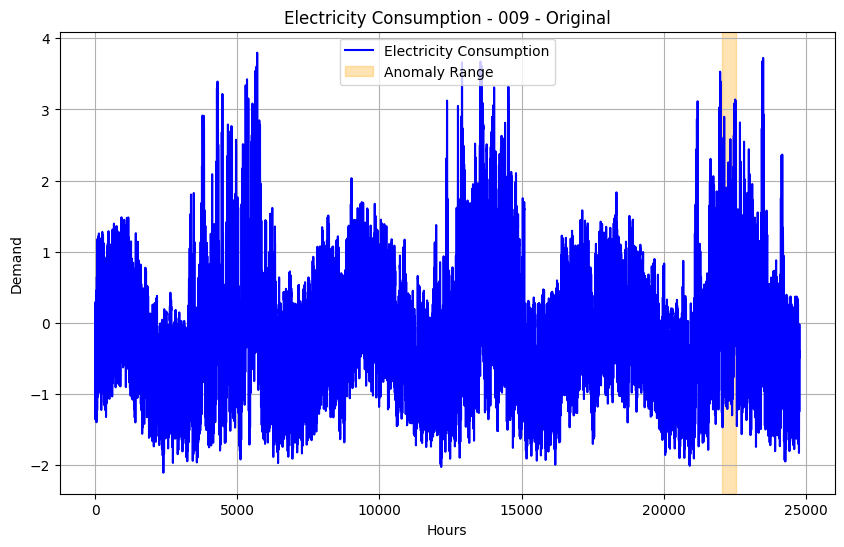

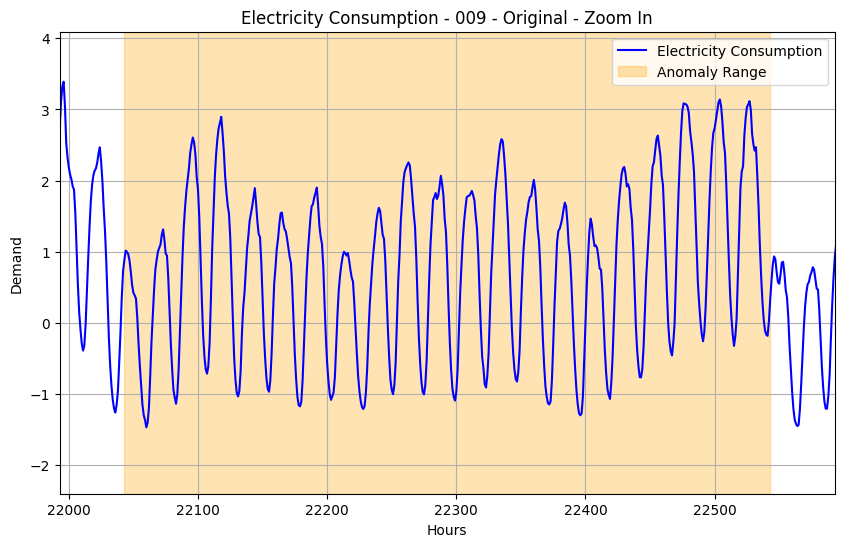

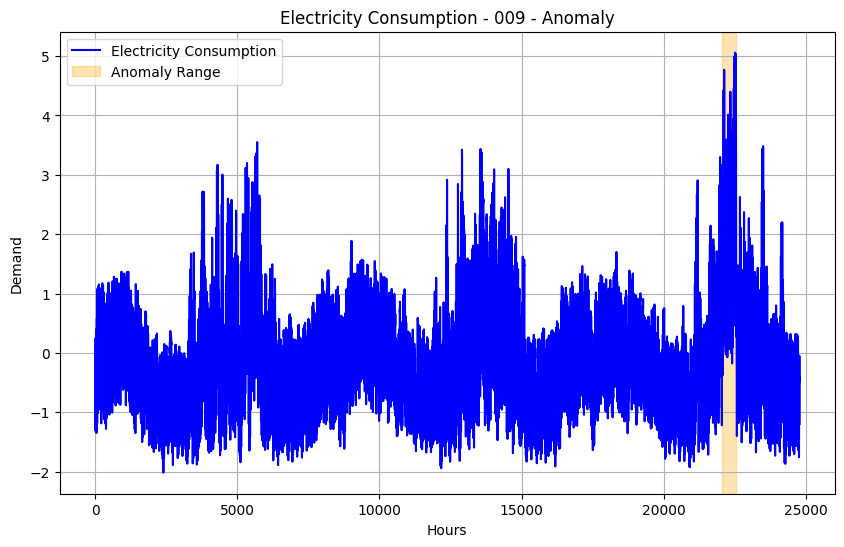

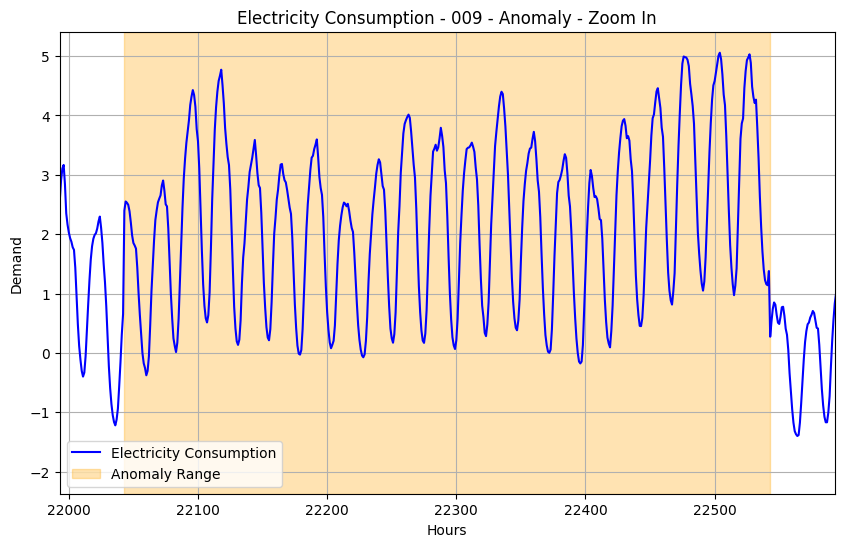

In [16]:
### "10.	(009 – Bigger) Make peaks bigger"
if anomaly_format == "009" or anomaly_format == "ALL":
    
    print("10.	(009 – Bigger) Make peaks bigger")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)
    
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Start and End Values of range
    start_index = highlight_start
    end_index = highlight_end
    
    # Add anomaly
    anomaly = data[:]  # Create a copy of the original list
        
    # Flattening the list
    flattened_list = flatten_list(anomaly)
    anomaly = flattened_list[:]    

    for i in range(start_index, end_index):
        anomaly[i] = anomaly[i] * peaks_percentage_increase

    # Z-normalize data
    data = z_normalize(data)
    anomaly = z_normalize(anomaly)

    # Plot the Time Series + Anomaly
    plot_time_series(data, "009", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    
    plot_time_series(anomaly, "009", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    filename_save = f"009_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"
    
    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')    
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])

11.	(010 – Smaller) Make peaks smaller


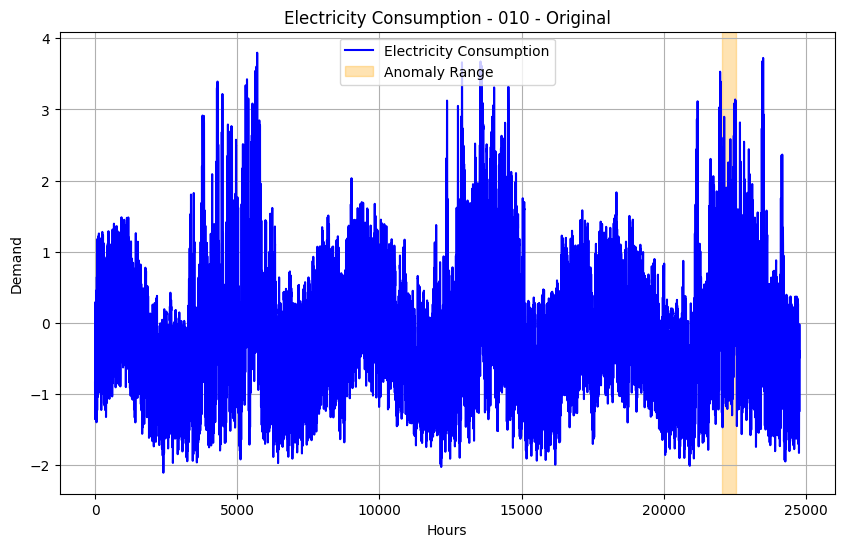

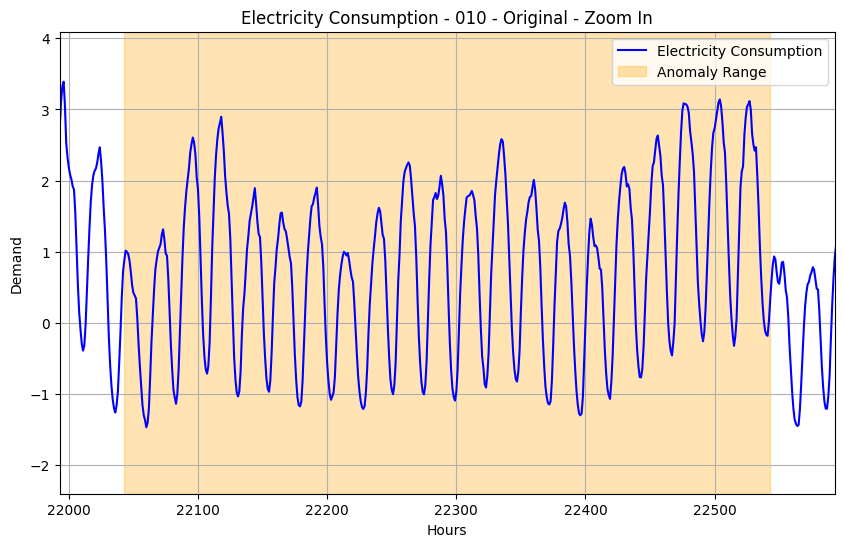

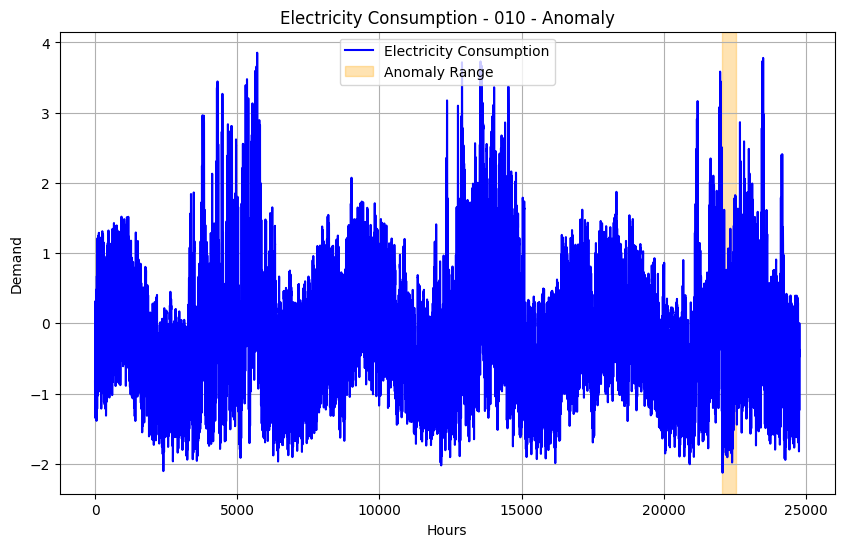

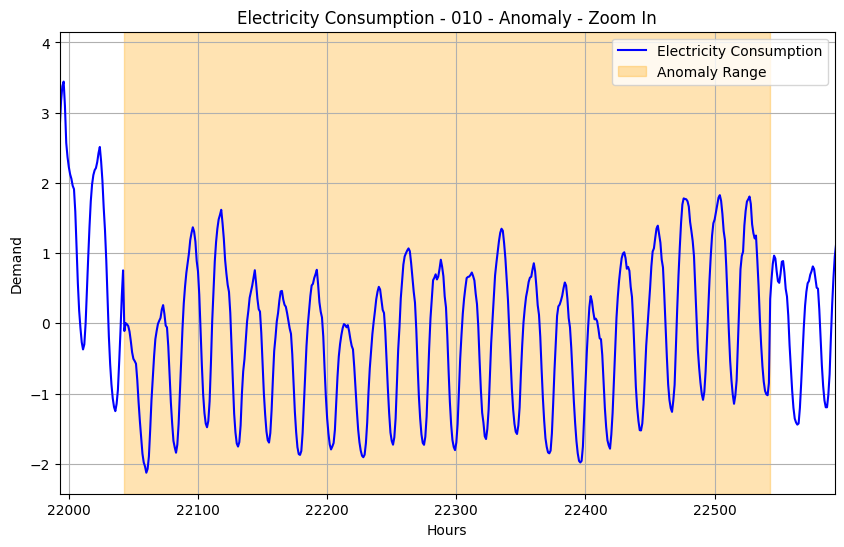

In [17]:
### "11.	(010 – Smaller) Make peaks smaller"
if anomaly_format == "010" or anomaly_format == "ALL":
    
    print("11.	(010 – Smaller) Make peaks smaller")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)
    
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Start and End Values of range
    start_index = highlight_start
    end_index = highlight_end
    
    # Add anomaly
    anomaly = data[:]  # Create a copy of the original list
        
    # Flattening the list
    flattened_list = flatten_list(anomaly)
    anomaly = flattened_list[:]    
    
    # Anomaly Peak Decrease
    for i in range(start_index, end_index):
        anomaly[i] = anomaly[i] * peaks_percentage_decrease

    # Z-normalize data
    data = z_normalize(data)
    anomaly = z_normalize(anomaly)

    # Plot the Time Series + Anomaly
    plot_time_series(data, "010", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    
    plot_time_series(anomaly, "010", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    filename_save = f"010_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"
    
    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')    
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])

12.	(011 – UpsideDown) Turn the data upside down


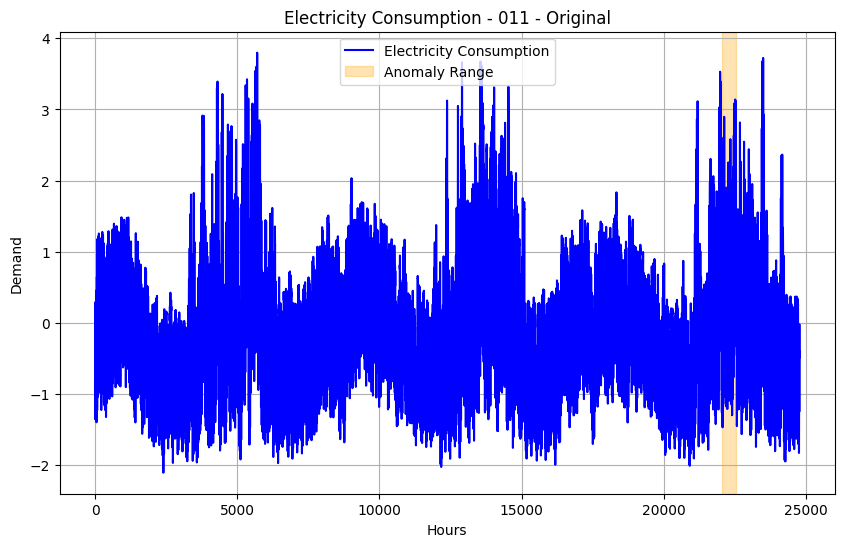

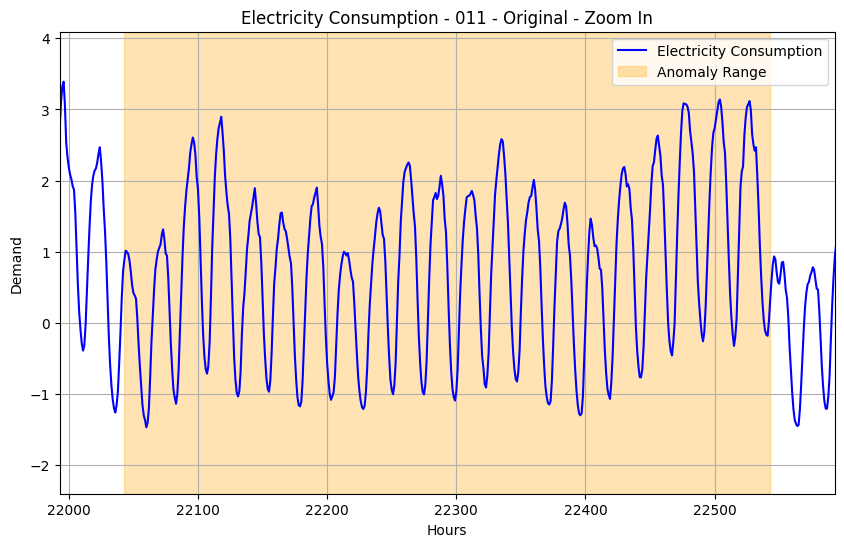

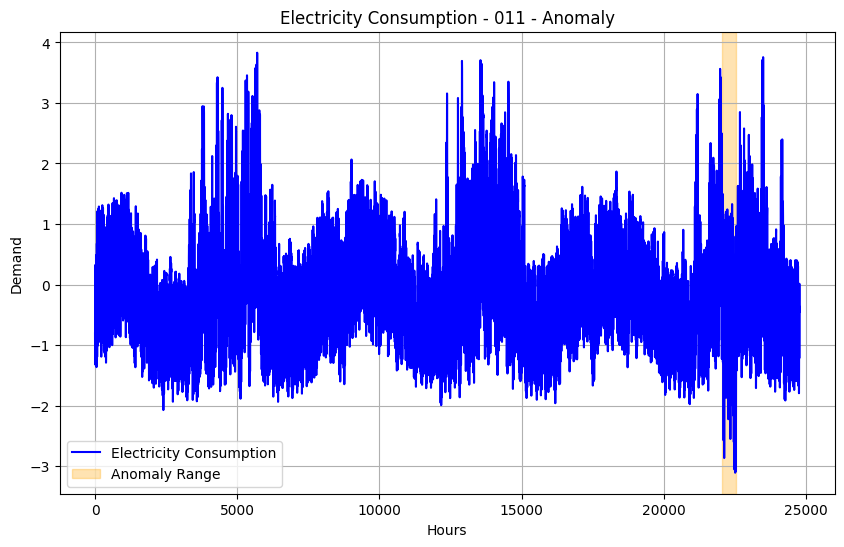

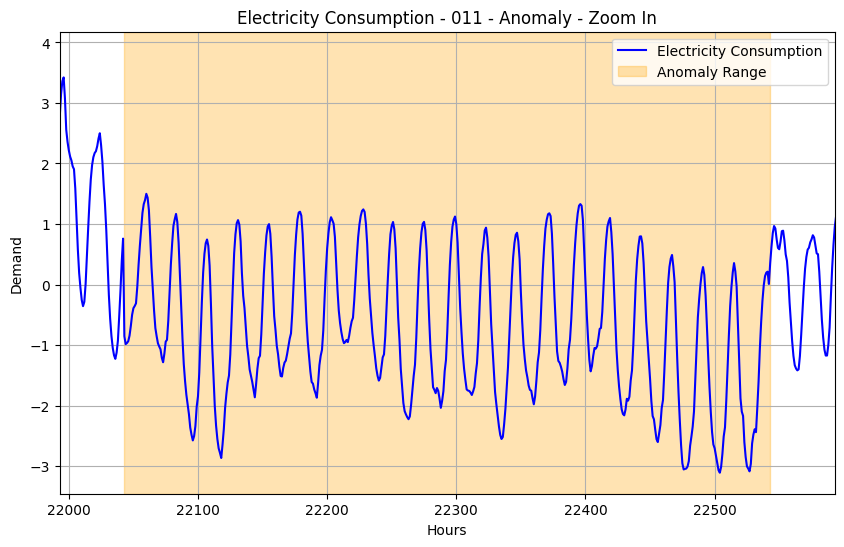

In [18]:
### 12.	(011 – UpsideDown) Turn the data upside down
if anomaly_format == "011" or anomaly_format == "ALL":
    
    print("12.	(011 – UpsideDown) Turn the data upside down")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)
    
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Start and End Values of range
    start_index = highlight_start
    end_index = highlight_end
    
    # Add anomaly
    anomaly = data[:]  # Create a copy of the original list
        
    # Flattening the list
    flattened_list = flatten_list(anomaly)
    
    mean_value = np.mean(flattened_list)
    
    data = data[:]
    anomaly = flattened_list[:]
    
    current = highlight_start
    while current < highlight_end:
        top = anomaly[current] - mean_value
        upside_down = mean_value - top
        anomaly[current] = upside_down
        current = current + 1

    # Z-normalize data
    data = z_normalize(data)
    anomaly = z_normalize(anomaly)

    # Plot the Time Series + Anomaly
    plot_time_series(data, "011", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    
    plot_time_series(anomaly, "011", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    filename_save = f"011_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"
    
    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')    
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])

13.	(012 – SineAdd) Add sin wave to the curve


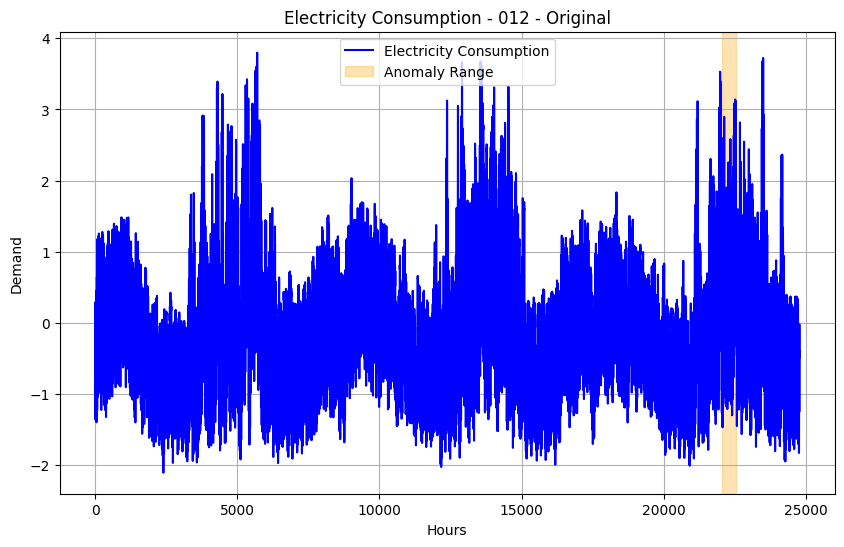

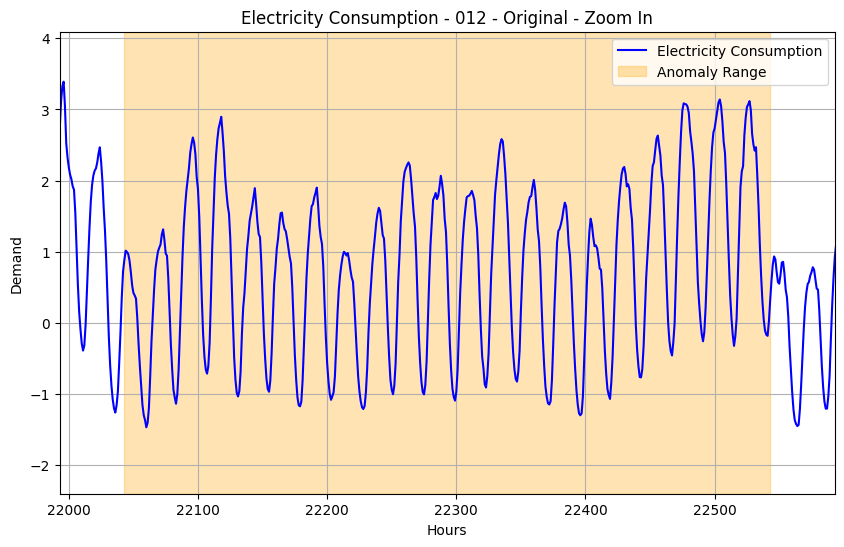

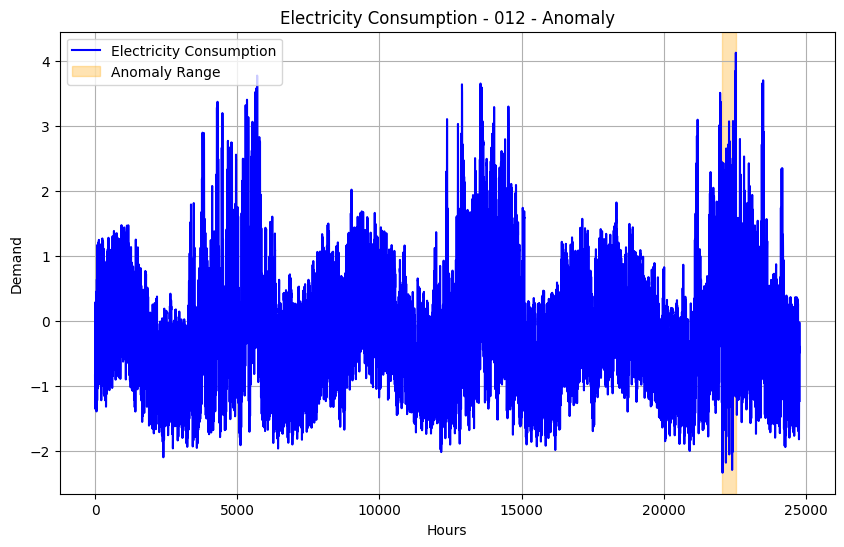

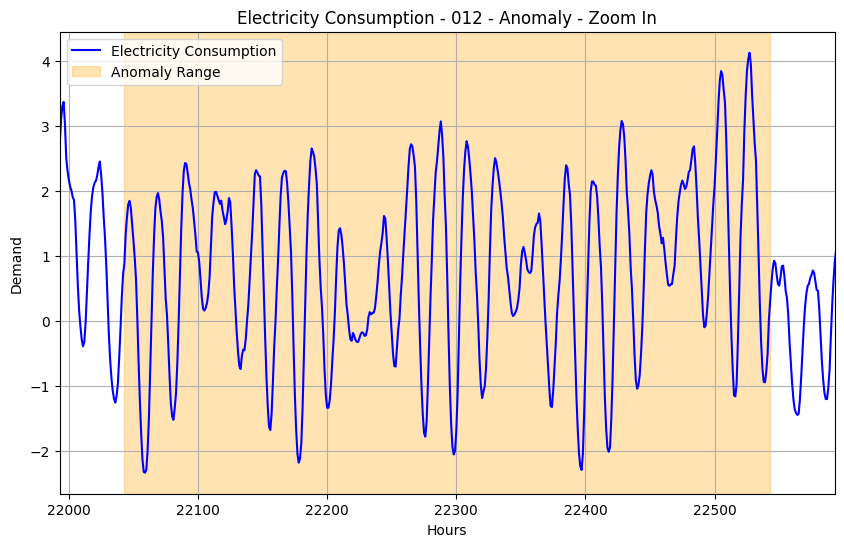

In [19]:
### 13.	(012 – SineAdd) Add sin wave to the curve
if anomaly_format == "012" or anomaly_format == "ALL":
    
    print("13.	(012 – SineAdd) Add sin wave to the curve")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)
    
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Start and End Values of range
    start_index = highlight_start
    end_index = highlight_end
    
    # Add anomaly
    anomaly = data[:]  # Create a copy of the original list
        
    # Flattening the list
    flattened_list = flatten_list(anomaly)
    
    max_value = max(flattened_list)
    mean_value = np.mean(flattened_list)
    max_with_mean = max_value - mean_value
    
    data = data[:]
    anomaly = flattened_list[:]
    
    # Sine Wave Parameters
    amplitude = max_with_mean
    amplitude = 1000
    frequency = 25  # Frequency of the sine wave in Hz
    time = np.linspace(0, 1, anomaly_range)  # Generating 1000 time points from 0 to 1 (in seconds)
    # Generate the sine wave
    sine_wave = amplitude * np.sin(2 * np.pi * frequency * time)
    
    current = highlight_start
    i = 0
    while current < highlight_end:
        anomaly[current] = sine_wave[i] + data[current]

        # Removing brackets using strip method
        array_as_string = np.array2string(anomaly[current])
        stripped_number = array_as_string.strip("[]")
        # Converting the result to a float
        anomaly[current] = float(stripped_number)
        
        current = current + 1
        i = i + 1

    # Z-normalize data
    data = z_normalize(data)
    anomaly = z_normalize(anomaly)

    # Plot the Time Series + Anomaly
    plot_time_series(data, "012", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    
    plot_time_series(anomaly, "012", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    filename_save = f"012_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"
    
    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')    
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])

14.	(013 – RemovePeaks) Remove peaks change to the mean


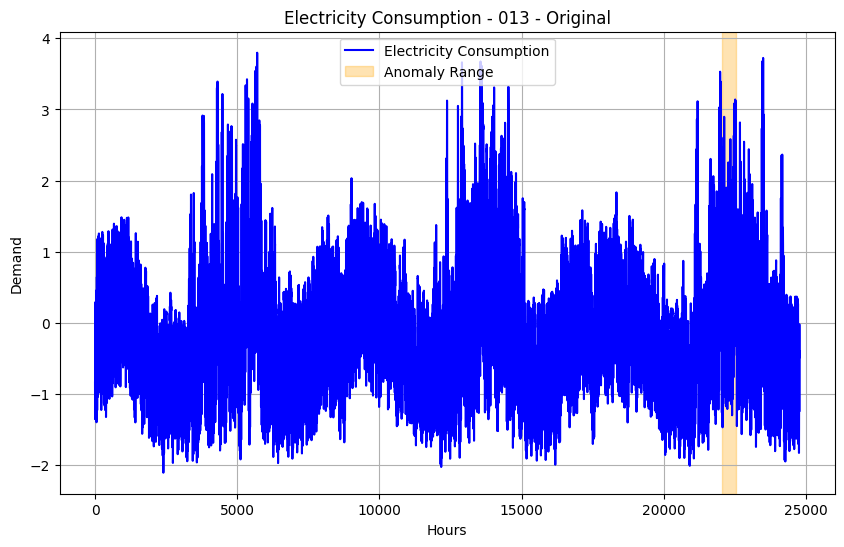

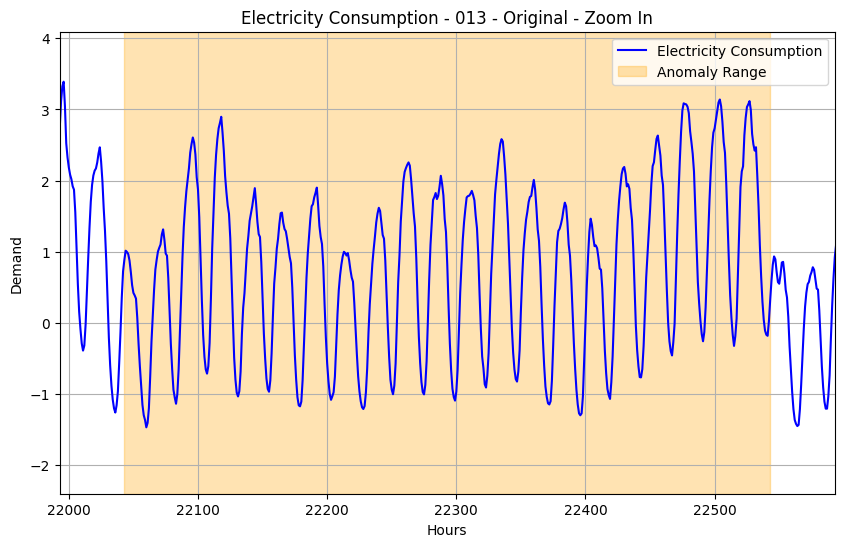

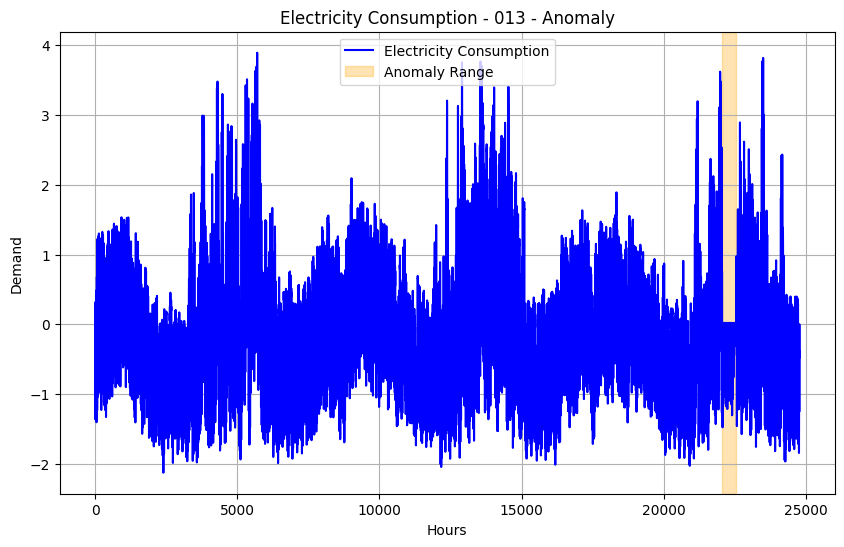

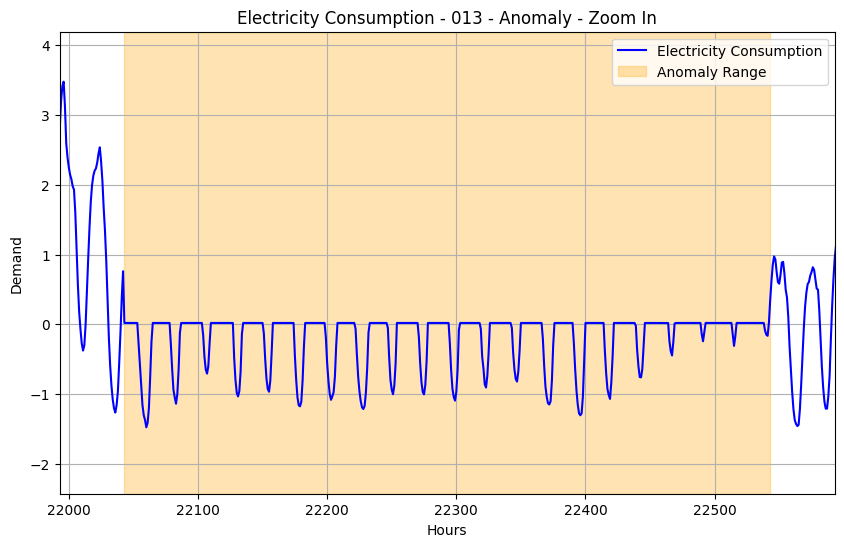

In [20]:
### 14.	(013 – RemovePeaks) Remove peaks change to the mean
if anomaly_format == "013" or anomaly_format == "ALL":
    
    print("14.	(013 – RemovePeaks) Remove peaks change to the mean")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)
    
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Start and End Values of range
    start_index = highlight_start
    end_index = highlight_end
    
    # Add anomaly
    anomaly = data[:]  # Create a copy of the original list
        
    # Flattening the list
    flattened_list = flatten_list(anomaly)
    anomaly = flattened_list[:]

    mean_value = np.mean(anomaly)
    max_value = np.max(anomaly)
    min_value = np.min(anomaly)

    # Anomaly Peak Decrease
    for i in range(start_index, end_index):
        if anomaly[i] > mean_value:
            anomaly[i] = mean_value

    # Z-normalize data
    data = z_normalize(data)
    anomaly = z_normalize(anomaly)

    # Plot the Time Series + Anomaly
    plot_time_series(data, "013", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    
    plot_time_series(anomaly, "013", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    filename_save = f"013_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"
    
    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')    
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])

15.	(014 – PeaksSameHeight) Make other peaks high like the highest peak


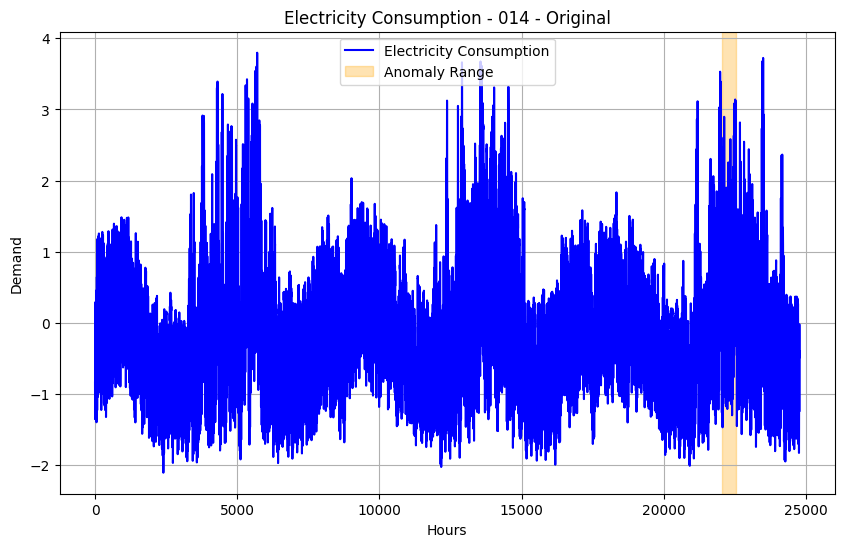

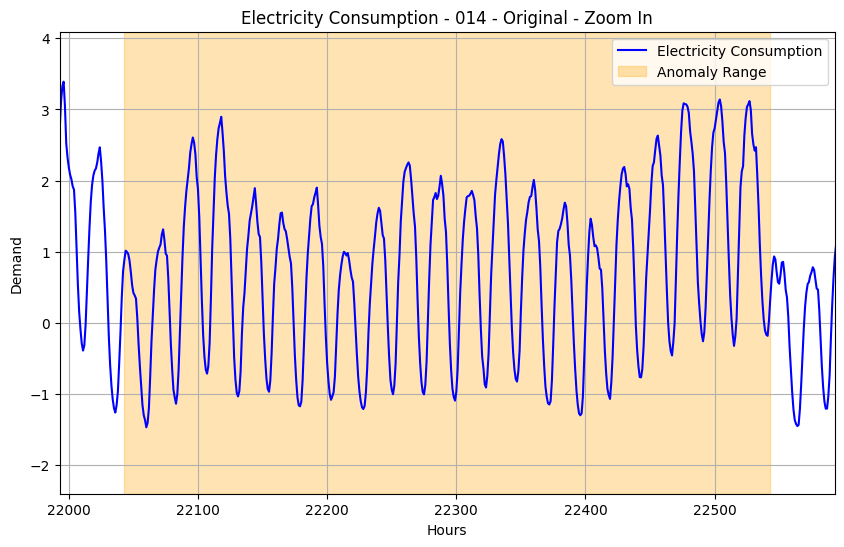

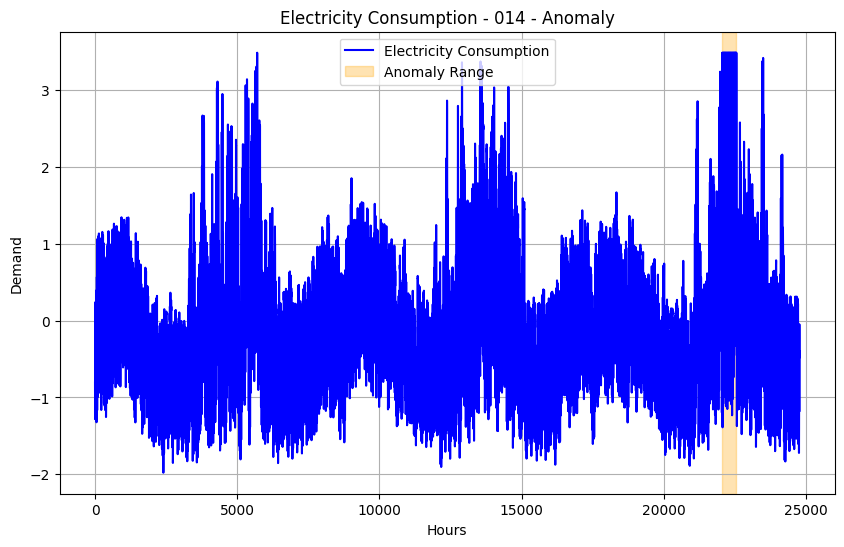

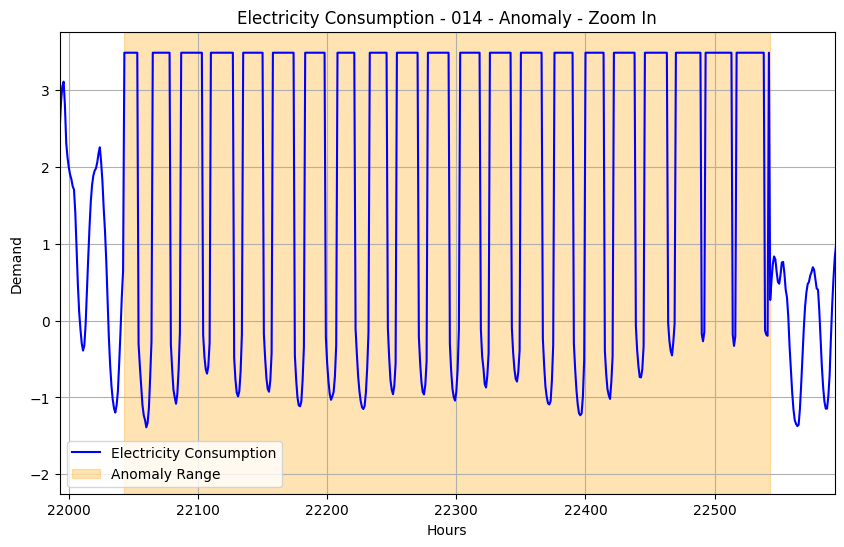

In [21]:
### 15.	(014 – PeaksSameHeight) Make other peaks high like the highest peak
if anomaly_format == "014" or anomaly_format == "ALL":
    
    print("15.	(014 – PeaksSameHeight) Make other peaks high like the highest peak")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)
    
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Start and End Values of range
    start_index = highlight_start
    end_index = highlight_end
    
    # Add anomaly
    anomaly = data[:]  # Create a copy of the original list
        
    # Flattening the list
    flattened_list = flatten_list(anomaly)
    anomaly = flattened_list[:]
   
    mean_value = np.mean(anomaly)
    max_value = np.max(anomaly)
    min_value = np.min(anomaly)

    # Anomaly Peak Decrease
    for i in range(start_index, end_index):
        if anomaly[i] > mean_value:
            anomaly[i] = max_value

    # Z-normalize data
    data = z_normalize(data)
    anomaly = z_normalize(anomaly)

    # Plot the Time Series + Anomaly
    plot_time_series(data, "014", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    
    plot_time_series(anomaly, "014", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    filename_save = f"014_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"
    
    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')    
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])

16.	(015 – Random Walk) Add random walk


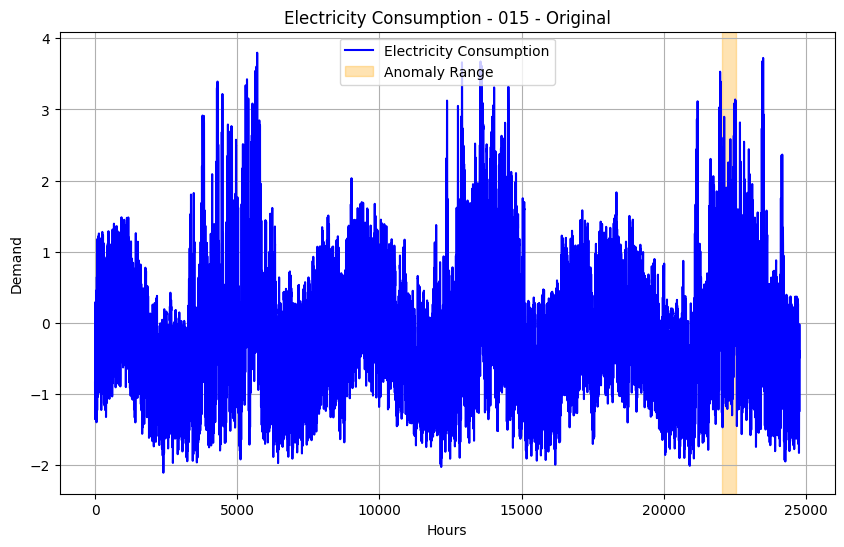

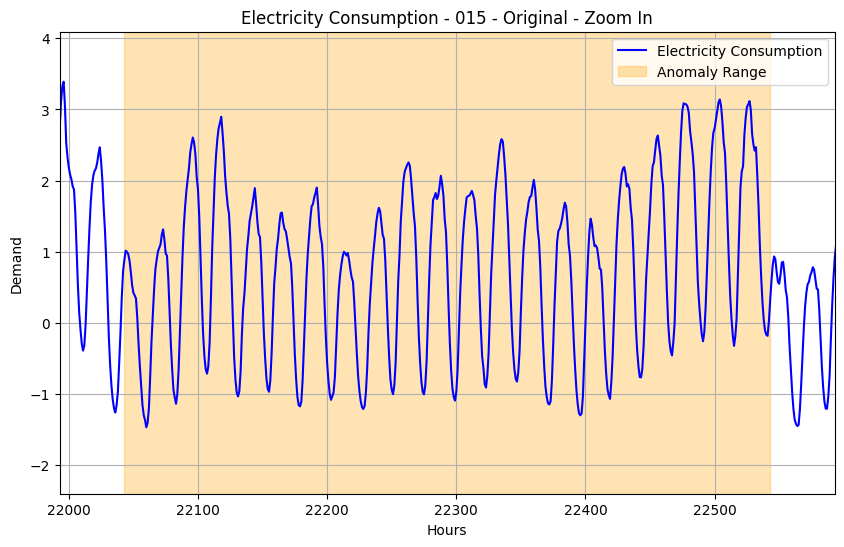

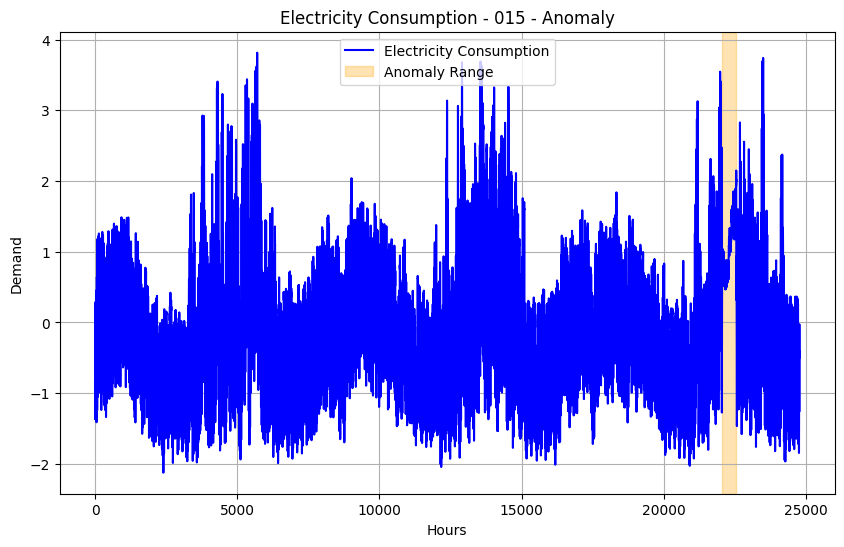

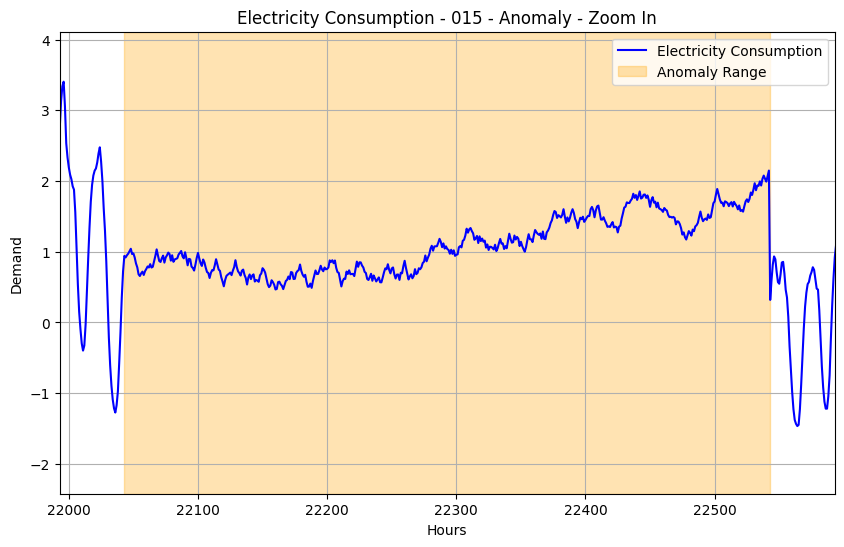

In [22]:
### 16.	(015 – Random Walk) Add random walk
if anomaly_format == "015" or anomaly_format == "ALL":
    
    print("16.	(015 – Random Walk) Add random walk")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)
    
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Start and End Values of range
    start_index = highlight_start
    end_index = highlight_end
    
    # Add anomaly
    anomaly = data[:]  # Create a copy of the original list
        
    # Flattening the list
    flattened_list = flatten_list(anomaly)
    
    mean_value = np.mean(flattened_list)
    max_value = max(flattened_list)
    min_value = min(flattened_list)
    
    data = data[:]
    anomaly = flattened_list[:]
    
    current = highlight_start
    previous = float(anomaly[highlight_start])
    while current < highlight_end:
        anomaly[current] = previous + random.randint(walk_min, walk_max)
        previous = anomaly[current]
        current = current + 1

    # Z-normalize data
    data = z_normalize(data)
    anomaly = z_normalize(anomaly)

    # Plot the Time Series + Anomaly
    plot_time_series(data, "015", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    
    plot_time_series(anomaly, "015", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    filename_save = f"015_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"
    
    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')    
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])

17.	(016 – Smooth) Make the anomaly smooth by moving average


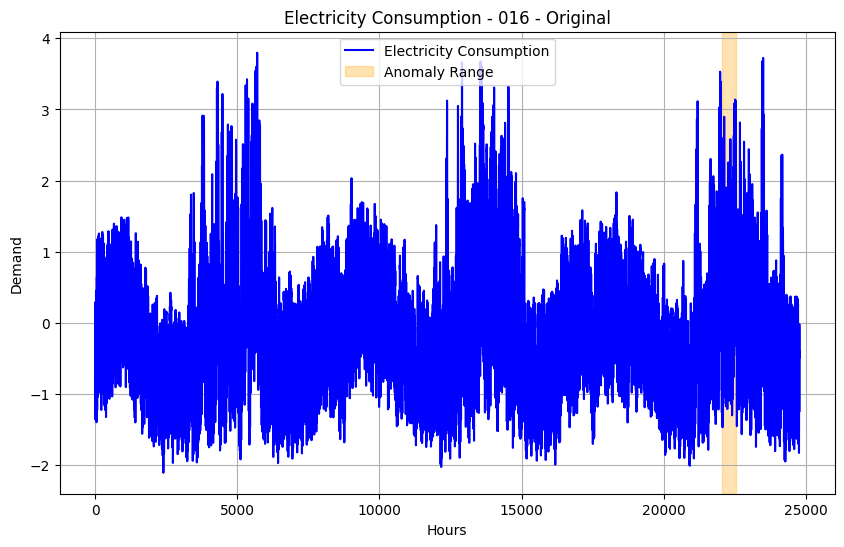

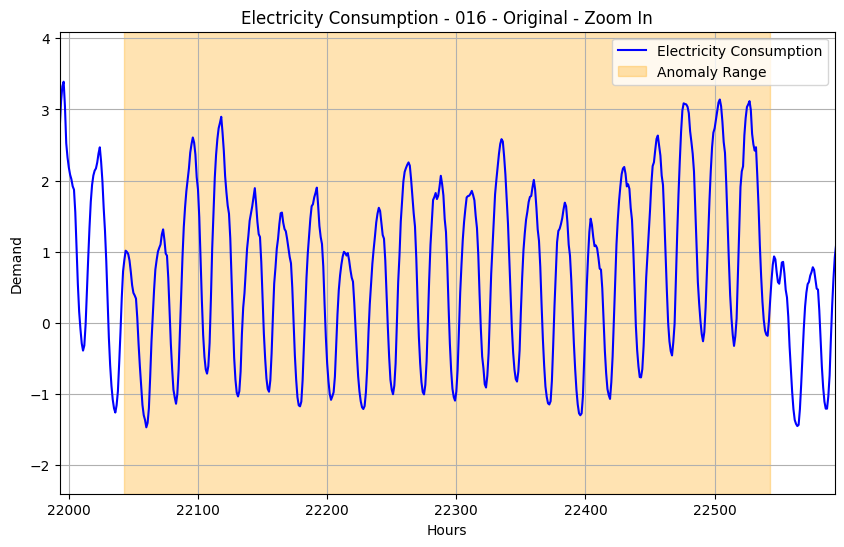

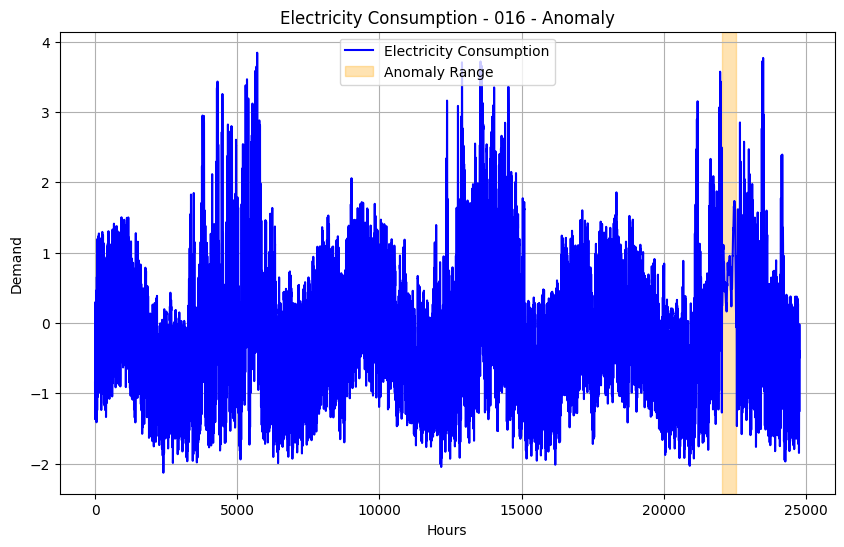

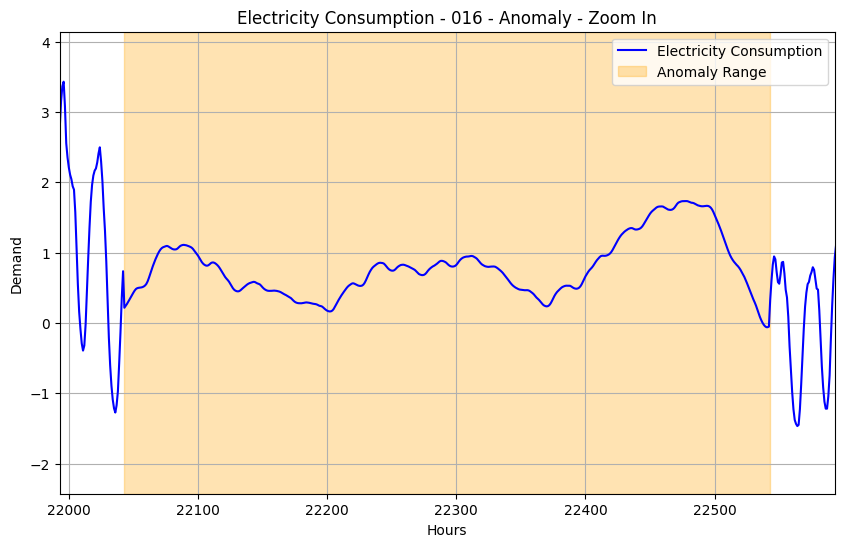

In [23]:
### 17.	(016 – Smooth) Make the anomaly smooth by moving average
if anomaly_format == "016" or anomaly_format == "ALL":
    
    print("17.	(016 – Smooth) Make the anomaly smooth by moving average")
    
    # Get data from filename
    data = []
    num_of_rows = 0
    
    with open(filename, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
        for row in tsv_reader:
            numeric_row = [float(value) for value in row]  # Convert each element to float
            data.append(numeric_row)
            num_of_rows += 1
        file.close()
    
    num_train = int(num_of_rows * train_percentage)
    
    # Anomalies
    anomaly_range_start = num_train + int(float(num_of_rows) * anomaly_range_start_percentage)
    #anomaly_range = int(num_of_rows * ((1.0-train_percentage) * anomaly_range_percentage))
    anomaly_range = anomaly_range_value

    highlight_start = anomaly_range_start
    highlight_end = anomaly_range_start + anomaly_range
        
    # Specify the range you want to zoom in on (adjust the start and end values)
    zoom_start = highlight_start - 50  # Start of the section to zoom in
    zoom_end = highlight_end + 50    # End of the section to zoom in

    # Start and End Values of range
    start_index = highlight_start
    end_index = highlight_end
    
    # Add anomaly
    anomaly = data[:]  # Create a copy of the original list
        
    # Flattening the list
    flattened_list = flatten_list(anomaly)

    anomaly = flattened_list[:]
    smoothed_data = anomaly[:]
    window_size = 50

    for i in range(start_index, end_index):
        window = data[i:i+window_size]
        average = sum(sum(sublist) for sublist in window) / window_size
        smoothed_data[i] = average    

    anomaly = smoothed_data[:]

    # Z-normalize data
    data = z_normalize(data)
    anomaly = z_normalize(anomaly)

    # Plot the Time Series + Anomaly
    plot_time_series(data, "016", True, zoom_start, zoom_end, anomaly_range_start, anomaly_range)    
    plot_time_series(anomaly, "016", False, zoom_start, zoom_end, anomaly_range_start, anomaly_range)

    # Write to File
    filename_save = f"016_UCR_Anomaly_{filename.replace('.txt', '')}_{str(num_train)}_{str(highlight_start)}_{str(highlight_end)}.txt"
    
    with open(filename_save, 'w', newline='') as csv_file:
        # Create a CSV writer with '\n' as the delimiter
        csv_writer = csv.writer(csv_file, delimiter='\n')    
        # Iterate over each float in anomaly, convert it to a list, and write to the CSV file
        for value in anomaly:
            csv_writer.writerow([value])